##### Imports

In [1]:
import os
# import sys
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# import itertools
import pickle

from astropy.io import fits
from scipy.optimize import curve_fit
from scipy.interpolate import make_interp_spline
from scipy.linalg import lstsq
from scipy.signal import find_peaks
from scipy.ndimage import median_filter, minimum_filter, maximum_filter

# import pandas as pd
# import ast

In [2]:
from simple_veloce_reduction import veloce_reduction_tools, veloce_config, veloce_wavecalib, veloce_logs

In [3]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import RANSACRegressor

In [4]:
from astropy.constants import c
c = c.value  # Speed of light in m/s
c

299792458.0

In [ ]:
# %pip install -U scikit-learn

# LC trace extraction

In [5]:
run = 'CSV_Run'
date = '230826'
arm = 'green'
ccd = 'ccd_2'
amplifier_mode = 4
# run = '23xmasRun'
# run = 'Delta_Call_2025_accretion'
input_dir = f'/home/usqobserver2/VeloceData/{run}/'
output_dir = '/home/usqobserver2/Joachim_veloce/Extracted_data/LC/'
science_targets = ['HD20203-USQ01']

In [6]:
veloce_paths = veloce_config.VelocePaths(input_dir=input_dir, output_dir=output_dir)
obs_list = veloce_logs.load_night_logs(date, science_targets, arm, veloce_paths=veloce_paths)

In [ ]:
# arm = 'red'
# filename = os.path.join(veloce_paths.trace_dir, f'veloce_{arm}_4amp_sim_calib_trace.pkl')
# traces = veloce_reduction_tools.Traces.load_traces(filename)

In [ ]:
ORDER, COEFFS, MATCH_LAM, MATCH_PIX, MATCH_LRES, GUESS_LAM, Y0 = veloce_reduction_tools.load_prefitted_wave(arm=arm, wave_path=veloce_paths.wave_dir)
traces = veloce_reduction_tools.Traces.load_traces(os.path.join(veloce_paths.trace_dir, f'veloce_{arm}_4amp_sim_calib_trace.pkl'))

In [8]:
### apply this pre-made wavelength solution to ThAr calibrations and check quality

In [9]:
arm_n = {'blue':1, 'green':2, 'red':3}

In [ ]:
# filename = f'26aug{arm_n[arm]}0083.fits' # LC
# filename = f'24aug{arm_n[arm]}0085.fits' # LC
# filename = f'24aug{arm_n[arm]}0232.fits' # LC
# filename = f'23dec{arm_n[arm]}0110.fits' # LC
filename = f'06apr{arm_n[arm]}0129.fits' # LC
# filename = '24aug30310.fits' # ThAr lamp
# spectrum_filename =  os.path.join(veloce_paths.input_dir, '230824', f'ccd_{arm_n[arm]}', filename)
# spectrum_filename =  os.path.join(veloce_paths.input_dir, '231223', f'ccd_{arm_n[arm]}', filename)
spectrum_filename =  os.path.join(veloce_paths.input_dir, '250406', f'ccd_{arm_n[arm]}', filename)

with fits.open(spectrum_filename) as hdul:
    image_data = hdul[0].data
    header = hdul[0].header

# plt.imshow(image_data, cmap='gray', norm="log")
image_substracted_bias = veloce_reduction_tools.remove_overscan_bias(image_data, hdr=header, arm=arm, amplifier_mode=2, overscan_range=32)

# plt.imshow(image_substracted_bias, cmap='gray', norm="log")
# extracted_ThAr_orders = veloce_reduction_tools.extract_orders_with_trace(image_substracted_bias, traces, summing_ranges)

Gain for half 1: 1.01
Gain for half 2: 0.97364


In [450]:
image_substracted_bias.shape

(4112, 4096)

In [419]:
# %matplotlib widget

In [420]:
# frame = image_substracted_bias.copy()
# ylen, xlen = frame.shape
# plt.imshow(frame, cmap='gray', norm='log', aspect='equal')
# # y = np.arange(ylen)

# for trace_y, trace_x, lower, upper in traces:
#     plt.plot(trace_x+32,trace_y, c='r')
#     plt.plot(trace_x,trace_y, c='b')
#     # plt.plot(trace_x+upper+30,trace_y, ls=':', c='g')
#     # plt.plot(trace_x-lower+30,trace_y, ls='--', c='g')
# plt.xlim(0,xlen)

In [421]:

# plt.plot(extracted_ThAr_orders[6])
# plt.show()

In [422]:
# n = 1

# # for match_pix in MATCH_PIX[n-1]: ### green part needs shift by one order issue with labeling? 
# for match_pix in MATCH_PIX[n]:
#     plt.axline([match_pix+Y0[n], 0], [match_pix+Y0[n], 1], c='g')

# plt.plot(extracted_ThAr_orders[n])
# # plt.xlim(MATCH_PIX[n-1][0]-25+Y0[n],MATCH_PIX[n-1][0]+25+Y0[n])
# plt.xlim(MATCH_PIX[n][2]-25+Y0[n],MATCH_PIX[n][2]+25+Y0[n])
# # plt.xlim(2350,2400)
# plt.ylim(1000,3000)
# plt.xlabel('pix')
# plt.show()

In [423]:
# plt.close('all')

In [424]:
# for x in traces.x:
#     if np.any(np.isnan(x)):
#         print('nan')

In [462]:
traces = veloce_reduction_tools.Traces.load_traces(os.path.join(veloce_paths.trace_dir, f'veloce_{arm}_LC_trace.pkl'))

In [ ]:
traces.set_traces([(trace_y, trace_x+4) for trace_y, trace_x, _, _ in traces])

In [ ]:
traces.adjust_traces(image_substracted_bias, fit_width=7)

In [ ]:
# traces.set_summing_range([(5,5) for _ in traces.x])

In [ ]:
# filename_LC = f'veloce_{arm}_LC_trace'

In [ ]:
# traces.save_traces(filename_LC)

(1900.0, 2000.0)

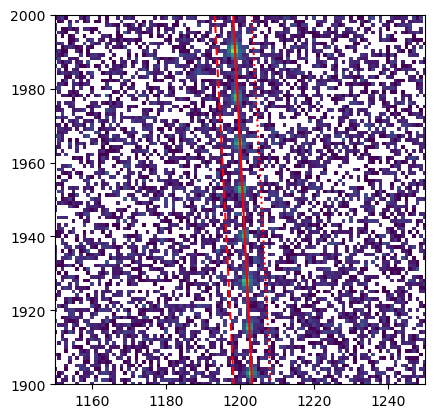

In [464]:
frame = image_substracted_bias.copy()
ylen, xlen = frame.shape
plt.imshow(frame, norm='log', aspect='equal')
# y = np.arange(ylen)

for trace_y, trace_x, lower, upper in traces:
    plt.plot(trace_x,trace_y, c='r')
    plt.plot(trace_x+upper,trace_y, ls=':', c='r')
    plt.plot(trace_x-lower,trace_y, ls='--', c='r')
# plt.xlim(0,xlen)
plt.xlim(1150,1250)
plt.ylim(1900, 2000)
# plt.xlim(1300,1400)
# plt.ylim(1900, 2000)


In [ ]:
# plt.close('all')

In [465]:
extracted_LC, extracted_LC_imgs = veloce_reduction_tools.extract_orders_with_trace(image_substracted_bias, traces)

In [466]:
wave = veloce_reduction_tools.calibrate_orders_to_wave(extracted_LC, Y0, COEFFS, traces=traces)

In [467]:
# filename = os.path.join(veloce_paths.output_dir, f'veloce_{arm}_LC_24aug{arm_n[arm]}0232.fits')
save_filename = os.path.join(veloce_paths.output_dir, f'veloce_{arm}_LC_{filename}')

print(f'Saving {save_filename}')
veloce_reduction_tools.save_extracted_spectrum_fits(save_filename, wave, extracted_LC, header)

Saving /home/usqobserver2/Joachim_veloce/Extracted_data/LC/Delta_Call_2025_accretion/veloce_red_LC_06apr30129.fits


'/home/usqobserver2/Joachim_veloce/Extracted_data/LC/Delta_Call_2025_accretion/veloce_red_LC_06apr30129.fits'

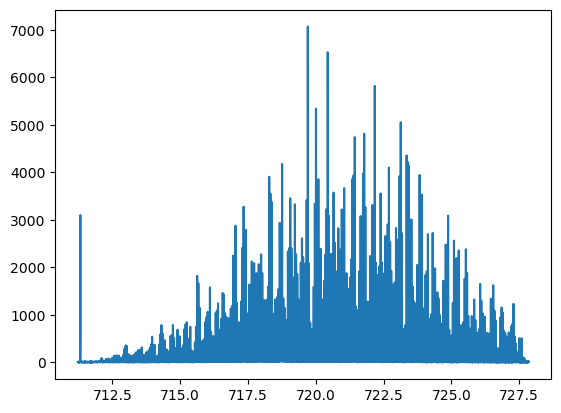

In [468]:
plt.plot(wave[20], extracted_LC[20])
# plt.xlim(720, 722.5)
# plt.xlim(720, 722.5)

In [ ]:
plt.close('all')

In [ ]:
# extracted_filename = '/home/usqobserver2/Joachim_veloce/Extracted_data/LC/veloce_red_LC_23dec30110.fits'
extracted_filename = '/home/usqobserver2/Joachim_veloce/Extracted_data/LC/Delta_Call_2025_accretion/veloce_red_LC_24aug30232.fits'
wave, extracted_LC, header = veloce_reduction_tools.load_extracted_spectrum_fits(extracted_filename)

In [11]:
wave_calib_data = veloce_wavecalib.load_LC_wave_calibration(veloce_paths, arm, header)

In [ ]:
# wave_calib_data = np.array(
#     list(zip(*wave_calib_data.T)),
#     dtype=[('wave', float), ('flux', float), ('pixel', float), ('order', int)])

In [ ]:
# unique_orders = list(set(wave_calib_data['order']))
# unique_orders

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40]

In [ ]:
for order in unique_orders:
    order_mask = wave_calib_data['order'] == order
    wave_calib_data['wave'][order_mask], wave_calib_data['flux'][order_mask], wave_calib_data['pixel'][order_mask]

In [27]:
i=0
for row in wave_calib_data:
    print(row)
    i+=1
    if i>10: break

[933.65922   16.831683 500.         1.      ]
[933.66592   23.762376 501.         1.      ]
[933.67262   28.712871 502.         1.      ]
[933.67932 207.92079 503.        1.     ]
[9.3368602e+02 2.9990099e+03 5.0400000e+02 1.0000000e+00]
[933.69272 466.33663 505.        1.     ]
[933.69942   59.405941 506.         1.      ]
[933.70611   31.683168 507.         1.      ]
[933.71281   23.762376 508.         1.      ]
[933.7195    20.792079 509.         1.      ]
[933.7262    11.881188 510.         1.      ]


In [29]:
for wave, intensity, pixel, order_num in zip(wave_calib_data[:,0], wave_calib_data[:,1], wave_calib_data[:,2], wave_calib_data[:,3]):
    print(tuple([wave, intensity, pixel, order_num]))
    break

(933.65922, 16.831683, 500.0, 1.0)


In [13]:
wave_calib_data[:,3]

array([ 1.,  1.,  1., ..., 40., 40., 40.])

In [18]:
order = 40
wave_calib_data[np.where(wave_calib_data[:,3] == order)]

array([[5.8330074e+02, 2.9702970e+00, 5.0000000e+02, 4.0000000e+01],
       [5.8330507e+02, 1.5841584e+01, 5.0100000e+02, 4.0000000e+01],
       [5.8330941e+02, 1.2871287e+01, 5.0200000e+02, 4.0000000e+01],
       ...,
       [5.9447678e+02, 1.8811881e+01, 3.8980000e+03, 4.0000000e+01],
       [5.9447912e+02, 9.9009901e+00, 3.8990000e+03, 4.0000000e+01],
       [5.9448146e+02, 1.5841584e+01, 3.9000000e+03, 4.0000000e+01]])

# ThXe ARC lamp Calibration

##### Functions

In [5]:
def load_vald_linelist(file):
    # types = np.array([str, str, float, float, float, float, float, str, float, float, str, str, str, str, str, str, int, int, str, str, str, str])
    types = np.array(['<U4', 'f', 'f', 'f', 'f', 'f', 'f', 'f', '<U90'])
    columns = np.array(['Elm_Ion', 'WL_air(nm)', 'Excit(eV)', 'log_gf', 'Rad.', 'Stark', 'Waals', 'Lande', 'References'], dtype=str)
    with open(file, 'r') as f:
        lines = f.readlines()
        data = []
        for line in lines:
            if line.startswith('#') or not line.strip():
                continue
            else:
                # values = line.strip().split(',')
                values = np.array([str(value).strip("'").strip() if (value.startswith("'") and value.endswith("'")) else value.strip() for value in line.strip().split(',')], dtype=str)
                # values = np.array([value.strip() for value in line.strip().split(',')], dtype=str)
                data.append(values)

    # Drop empty columns
    data = [tuple(row) for row in data]
    dtype = [(col, t) for col, t in zip(columns, types)]
    data = np.array(data, dtype=dtype)
    return data

In [6]:
def load_NIST_linelist(file):
    # types = np.array([str, str, float, float, float, float, float, str, float, float, str, str, str, str, str, str, int, int, str, str, str, str])
    types = np.array(['<U2','<U1','f','f','f','<U16','<U16','<U16','f','f','<U16','<U16','<U4','<U16','<U16','<U4','uint','uint','<U16','<U16','<U16','<U4'])
    with open(file, 'r') as f:
        lines = f.readlines()
        columns = np.array(lines[0].strip().split(',')[:-1], dtype=str) # get column names
        columns = np.append(columns, 'intens_flag') # add intensity flag column
        mask = np.ones_like(columns, dtype=bool)
        data = []
        for line in lines[1:]:
            # values = line.strip().split(',')
            if len(line.strip().split(',')[:-1]) == len(columns)-1:
                values = np.array([value[4:-3] if (value.startswith('"') and value.endswith('"')) else value for value in line.strip().split(',')[:-1]], dtype=str)
                # split intensity and flag to seperate columns
                intens_flag = ''.join(filter(lambda x: not x.isdigit(), values[4])) or '1' #flag for line with no intensity flag (clean ones?) will be set to 1
                values[4] = ''.join(filter(str.isdigit, values[4])) # leave only digits as intensity
                values = np.append(values, intens_flag) # append intensity flag to the end of the values
                if values[3] != '':
                    data.append(values)
                    mask *= np.array([value != '' for value in values]) # mask out columns with empty values best lines have all values anyway?
                else:
                    print(f'Skipping line at {values[2]}') # dropping lines without uncertainty that passed the website filter? only six or so
    # Drop empty columns
    data = [tuple(row[mask]) for row in data]
    columns = columns[mask]
    types = types[mask]
    dtype = [(col, t) for col, t in zip(columns, types)]
    data = np.array(data, dtype=dtype)
    
    return data

In [7]:
# def load_UVES_linelist(file):
#     types = np.array(['f', 'f', 'f', '<U2', '<U3', '<U1'])
#     columns = np.array(['wavenumber(cm-1)', 'air_wave(nm)', 'log_intens', 'Element', 'Ion', 'Reference'], dtype=str)
#     dtype = [(col, t) for col, t in zip(columns, types)]
#     with open(file, 'r') as f:
#         lines = f.readlines()
#         data = []
#         for line in lines:
#             values = np.array([value.strip() for value in line.strip().split()], dtype=str)
#             data.append(values)

#     # Drop empty columns
#     data = [tuple(row) for row in data]
#     dtype = [(col, t) for col, t in zip(columns, types)]
#     data = np.array(data, dtype=dtype)
#     # Convert vacuum to air wavelengths to meet label
#     data['air_wave(nm)'] = veloce_reduction_tools.vacuum_to_air(data['air_wave(nm)'])/10
#     return data

def load_UVES_linelist(file):
    types = np.array(['f', 'f', 'f', '<U2', '<U3', '<U1'])
    columns = ['wavenumber', 'air_wave', 'log_intens', 'Element', 'Ion', 'Reference']
    dtype = [(col, t) for col, t in zip(columns, types)]
    # with open(file, 'r') as f:
    #     lines = f.readlines()
    #     data = []
    #     for line in lines:
    #         values = np.array([value.strip() for value in line.strip().split()], dtype=str)
    #         data.append(values)
    data = np.genfromtxt(file, dtype=dtype, delimiter=None, names=columns, encoding='utf-8', autostrip=True)
    data['air_wave'] = data['air_wave'] / 10  # Convert vacuum to air wavelengths to meet label
    # Drop empty columns
    # data = [tuple(row) for row in data]
    # dtype = [(col, t) for col, t in zip(columns, types)]
    # data = np.array(data, dtype=dtype)
    # Convert vacuum to air wavelengths to meet label
    # data['air_wave(nm)'] = veloce_reduction_tools.vacuum_to_air(data['air_wave(nm)'])/10
    return data

In [8]:
def general_gaussian(x, A, mu, sigma, beta, baseline):
    return A * np.exp(-np.abs(((x - mu)/(np.sqrt(2)*sigma)))**beta) + baseline

In [9]:
def normalise_thxe_order(y, nknots=10, plot=False):
    """
    Normalise the ThXe order by fitting a Gaussian to the peak and subtracting the baseline.
    """
    x = np.arange(len(y))
    smoothed = median_filter(minimum_filter(y, 100), size=500)
    x_fit = np.linspace(x.min(), x.max(), nknots)
    y_fit = np.interp(x_fit, x, smoothed)
    
    spline = make_interp_spline(x_fit, y_fit, k=3, bc_type=([(1, 0.0)], [(1, 0.0)]))
    baseline = spline(x)
    
    if plot:
        plt.figure(figsize=(10, 6))
        plt.plot(x, y, c='gray', label='Original', alpha=0.5)
        plt.plot(x, smoothed, ls='--', c='k', label='Smoothed')
        plt.scatter(x_fit, y_fit, s=10, c='k', label='Selected knots')
        plt.plot(x, baseline, c='r', label='B-spline fit')
        plt.xlabel('Pixel')
        plt.ylabel('Flux')
        plt.xlim(0, len(y))
        plt.ylim(0, np.max(smoothed) * 1.05)
        plt.legend()
        plt.title('Normalisation of ThXe Order')
        plt.show()

    return y/baseline
    

In [10]:
def get_lines_in_order(wave, linelist, elements=None, intensity_threshold=None, flag=None):
    """
    Get the lines in the order from the linelist.
    Wavelengths in linelist should be in air.
    """
    # Build mask for wavelength range
    mask = (linelist['obs_wl_air(nm)'] >= wave.min()) & (linelist['obs_wl_air(nm)'] <= wave.max())
    # Optional: intensity threshold
    if intensity_threshold is not None:
        # Filter linelist by intensity threshold
        if type(intensity_threshold) == int:
            min_intensity = intensity_threshold
            max_intensity = np.inf
        elif len(intensity_threshold) == 2:
            min_intensity, max_intensity = intensity_threshold
        else:
            raise ValueError("Intensity threshold should be a single value or a tuple of two values.")
        mask &= (linelist['intens'] >= min_intensity) & (linelist['intens'] <= max_intensity)
    # Optional: intensity flag
    if flag is not None:
        if isinstance(flag, str):
            mask &= (linelist['intens_flag'] == flag)
        elif isinstance(flag, list):
            mask &= np.isin(linelist['intens_flag'], flag)
        else:
            raise ValueError("Flag should be a string or a list of strings.")
    # Optional: element condition
    if elements is not None:
        mask &= np.isin(linelist['element'], elements)
    print(f"Found {np.sum(mask)} lines in the order.")
    return linelist[mask]

##### Load atomic data

In [11]:
nist_linelist = load_NIST_linelist('/home/usqobserver2/Joachim_veloce/veloce_reduction_dev/veloce_reduction/Wave/th_linelist_NIST.csv')


Skipping line at 493.709
Skipping line at 495.252
Skipping line at 542.038
Skipping line at 671.187
Skipping line at 674.037
Skipping line at 690.116


In [ ]:
# vald_linelist = load_vald_linelist('/home/usqobserver2/Joachim_veloce/veloce_reduction_dev/veloce_reduction/Wave/th_linelist_VALD.csv')

In [ ]:
# uves_linelist = load_UVES_linelist('/home/usqobserver2/Joachim_veloce/veloce_reduction_dev/veloce_reduction/Wave/thar_UVES_MM090311.dat', )
# uves_linelist = load_UVES_linelist('/home/usqobserver2/Joachim_veloce/veloce_reduction_dev/veloce_reduction/Wave/mnras0378-0221-SD1.txt', )

##### Load ARC ThXe calibration data

In [12]:
# run = "CSV_Run"
run = "WASP189b"
# date = "230826"
date = "240410"
# arm = 'red'
# arm = 'green'
arm = 'blue'
ccd_nums = {'red': 3, 'green': 2, 'blue': 1}
ccd = f'ccd_{ccd_nums[arm]}'
# amplifier_mode = 4
amplifier_mode = 2
# filename = '26aug20055.fits'
# filename = '26aug20061.fits'
# science_targets = ['HD20203-USQ01']
science_targets = ['WASP189b']

In [13]:
input_dir = f'/home/usqobserver2/VeloceData/{run}/'
# output_dir = '/home/usqobserver2/Joachim_veloce/Extracted_data/ThXe/'
output_dir = f'/home/usqobserver2/Joachim_veloce/Extracted_data/{run}/'

In [14]:
veloce_paths = veloce_config.VelocePaths(input_dir=input_dir, output_dir=output_dir)

In [15]:
obs_list = veloce_logs.load_night_logs(date, science_targets, arm, veloce_paths=veloce_paths)

In [16]:
obs_list[f'ARC-ThAr_{arm}'][date]

['10apr10066.fits',
 '10apr10067.fits',
 '10apr10068.fits',
 '10apr10069.fits',
 '10apr10070.fits',
 '10apr10071.fits',
 '10apr10072.fits',
 '10apr10169.fits',
 '10apr10170.fits',
 '10apr10171.fits']

In [17]:
# file_list = obs_list[f'ARC-ThAr_{arm}'][date][:-3]
# file_list

In [18]:
# data, header = veloce_reduction_tools.get_master_mmap(file_list, f'ARC-ThAr_{arm}', input_dir, date, arm, amplifier_mode)

In [19]:
# master_filename = f'Master/master_ARC-ThAr_{arm}_{date}.fits'
master_filename = f'{veloce_paths.master_dir}/master_ARC-ThAr_{arm}_{date}.fits'
# veloce_reduction_tools.save_image_fits(master_filename, data, header)
with fits.open(master_filename) as hdul:
    data= hdul[0].data
    header = hdul[0].header

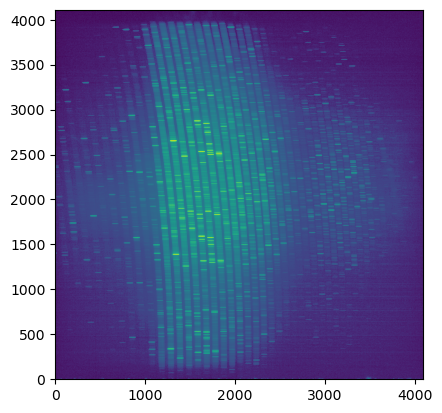

In [20]:
plt.close('all')
plt.imshow(data, origin='lower', norm='symlog')
plt.show()

In [21]:
traces = veloce_reduction_tools.Traces.load_traces(os.path.join(veloce_paths.trace_dir, f'veloce_{arm}_4amp_sim_calib_trace.pkl'))
# traces = veloce_reduction_tools.Traces.load_traces(os.path.join(veloce_paths.trace_dir, f'veloce_{arm}_4amp_no_sim_calib_trace.pkl'))

In [22]:
extracted_ThXe, extracted_ThXe_imgs = veloce_reduction_tools.extract_orders_with_trace(data, traces)

In [23]:
ORDER, COEFFS, MATCH_LAM, MATCH_PIX, MATCH_LRES, GUESS_LAM, Y0 = veloce_reduction_tools.load_prefitted_wave(arm=arm, wave_path=veloce_paths.wave_dir)

In [24]:
wave = veloce_reduction_tools.calibrate_orders_to_wave(extracted_ThXe, Y0, COEFFS, traces=traces)

### Fit Th lines

##### Plot selesced order with line positions

In [25]:
%matplotlib widget

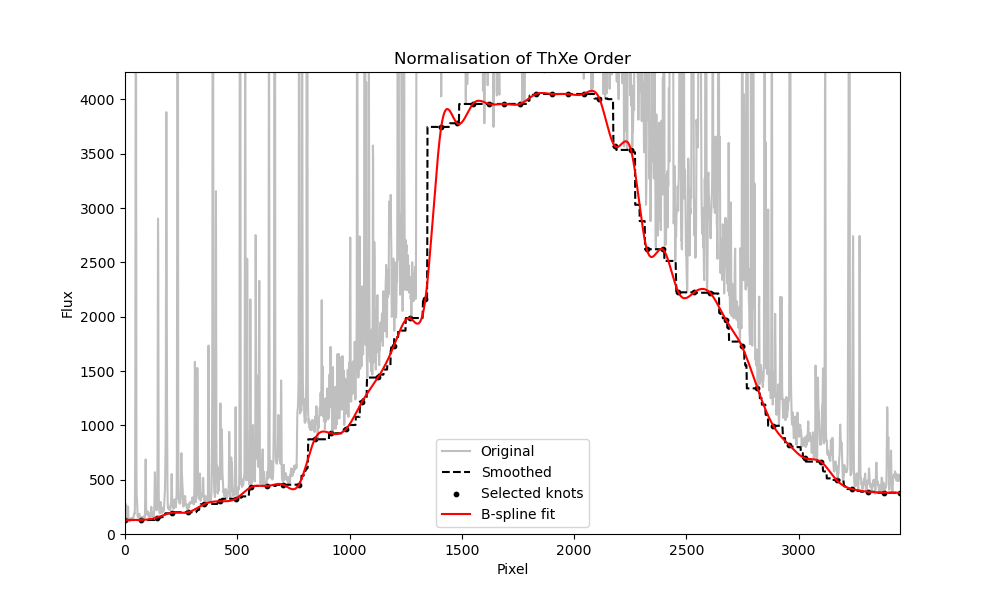

array([0.99993068, 1.14612938, 1.36143574, ..., 1.31771692, 1.31250202,
       1.42708336])

In [26]:
plt.close('all')
order = 9
normalise_thxe_order(extracted_ThXe[order], nknots=50, plot=True)
# plt.show()

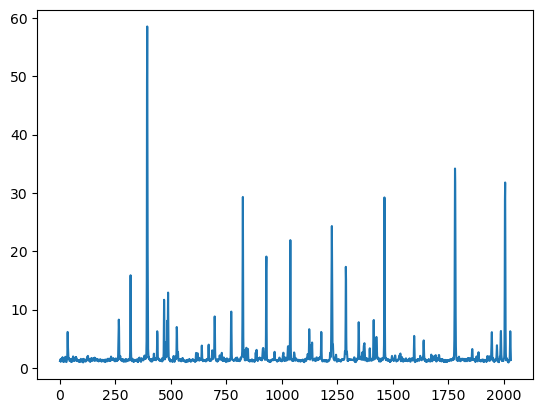

In [98]:
plt.close('all')
order = 20
plt.plot(normalise_thxe_order(extracted_ThXe[order], nknots=50, plot=False))
plt.show()

2033
1000.0 3032.0 383.09660967261124 387.5410610720279
Found 73 lines in the order.


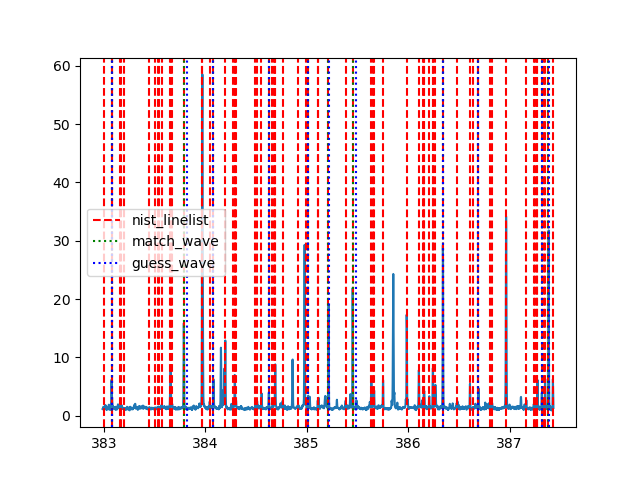

In [89]:
plt.close('all')
order = 20
# plt.plot(veloce_reduction_tools.vacuum_to_air(wave[order]), extracted_ThXe[order])
# Smooth the data
print(len(wave[order]))
print(traces.y[order][0], traces.y[order][-1], wave[order][0], wave[order][-1])
if arm == 'red':
    # not normalising as very bright oversaturated lines mess with my normalisation
    plt.plot(veloce_reduction_tools.vacuum_to_air(wave[order]), extracted_ThXe[order], label='Data')
elif arm == 'green':
    plt.plot(veloce_reduction_tools.vacuum_to_air(wave[order]), normalise_thxe_order(extracted_ThXe[order]), label='normalised Data')
elif arm == 'blue':
    plt.plot(veloce_reduction_tools.vacuum_to_air(wave[order]), normalise_thxe_order(extracted_ThXe[order], nknots=50))
else:
    raise ValueError(f"Arm {arm} does not exist, valid arms are ['red', 'green' and 'blue'].")
    

lines = get_lines_in_order(veloce_reduction_tools.vacuum_to_air(wave[order]), nist_linelist, elements=['Th', 'Xe'], intensity_threshold=200, flag=['1'])
# lines = get_lines_in_order(veloce_reduction_tools.vacuum_to_air(wave[order]), nist_linelist, elements=['Th', 'Xe'], intensity_threshold=100)
for line in lines:
    plt.axvline(line['obs_wl_air(nm)'], c='r', ls='--', label="nist_linelist")

# for line in uves_linelist[(uves_linelist['air_wave'] >= wave[20].min()) & (uves_linelist['air_wave'] <= wave[20].max())]:
#     plt.axvline(line['air_wave'], c='orange', ls='--', label="uves_linelist")

# for line in vald_linelist[(vald_linelist['WL_air(nm)'] >= wave[20].min()) & (vald_linelist['WL_air(nm)'] <= wave[20].max())]:
#     plt.axvline(line['WL_air(nm)'], c='orange', ls='--', label="vald_linelist")

for match_wave in MATCH_LAM[order]:
    plt.axvline(veloce_reduction_tools.vacuum_to_air(match_wave), c='g', ls=':', label="match_wave")

for guess_wave in GUESS_LAM[order]:
    plt.axvline(veloce_reduction_tools.vacuum_to_air(guess_wave), c='b', ls=':', label="guess_wave")
# Remove duplicate labels in legend
handles, labels = plt.gca().get_legend_handles_labels()
unique = dict()
for h, l in zip(handles, labels):
    if l not in unique:
        unique[l] = h
plt.legend(unique.values(), unique.keys())
# plt.xlim(496.27, 496.34)
plt.show()

In [60]:
len(MATCH_LAM[order])

19

##### Single order with plots

In [96]:
%matplotlib inline
plt.close('all')

Found 73 lines in the order.
Fitting line 435.937 nm at pixel 266.44, peak height 5.07, floor 1.21


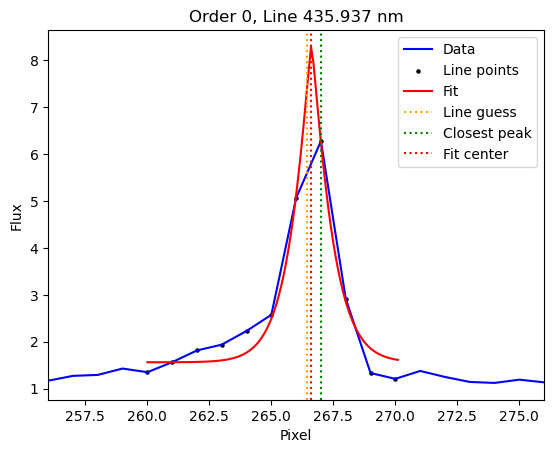

Fitting line 436.017 nm at pixel 290.95, peak height 1.05, floor 1.27


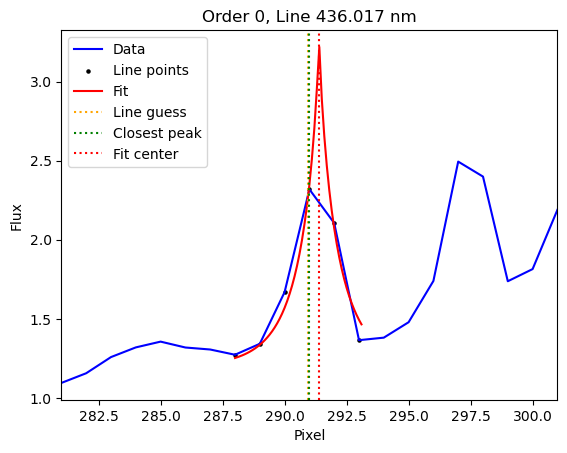

Peak height for line 436.247 nm is too low: 0.57.
Fitting line 436.593 nm at pixel 471.34, peak height 12.51, floor 1.25


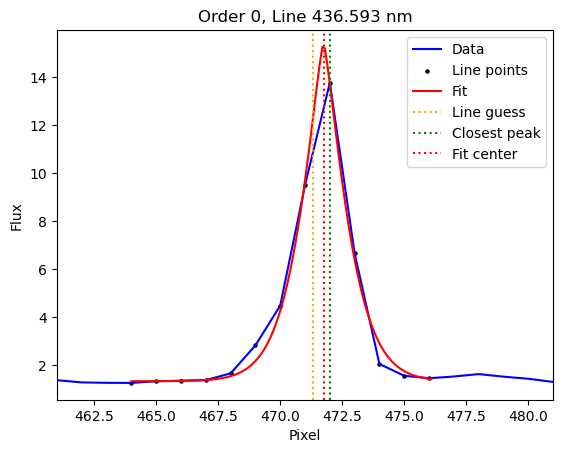

Line 436.729 nm is asymmetric 0.31 - probably a blend
Line 436.742 nm is asymmetric 0.31 - probably a blend
Line 436.929 nm is asymmetric 0.32 - probably a blend
Fitting line 436.949 nm at pixel 585.43, peak height 2.78, floor 1.28


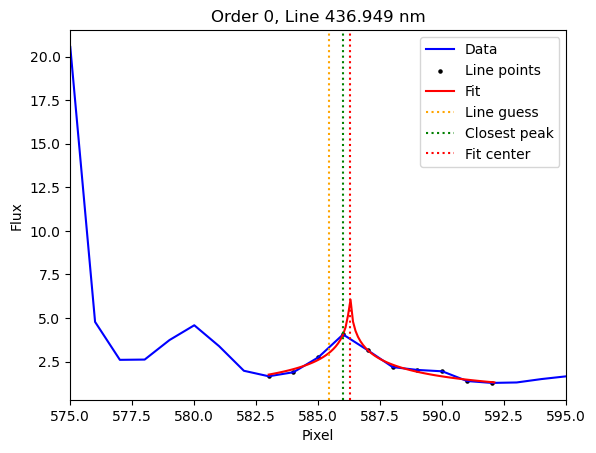

Fitting line 436.988 nm at pixel 597.75, peak height 6.48, floor 1.17


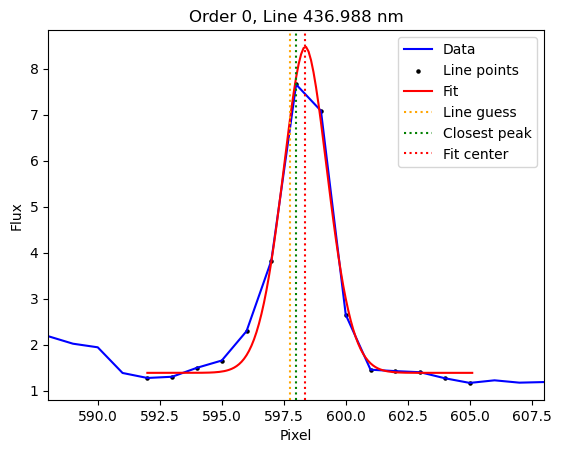

Line 437.304 nm is asymmetric 0.34 - probably a blend
Line 437.390 nm is asymmetric 0.35 - probably a blend
Line 437.401 nm is asymmetric 0.35 - probably a blend
Fitting line 437.412 nm at pixel 736.60, peak height 25.28, floor 1.31


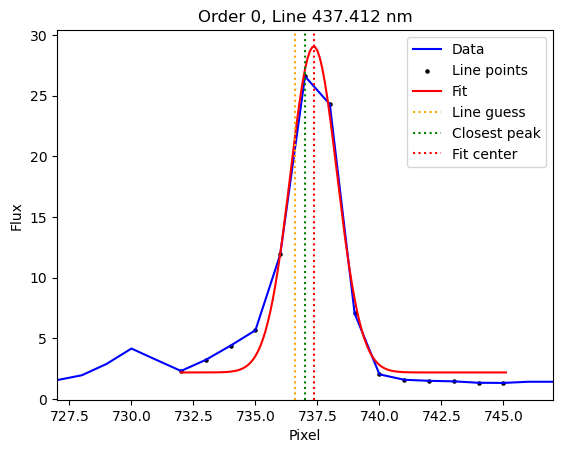

Fitting line 437.479 nm at pixel 758.48, peak height 8.24, floor 1.20


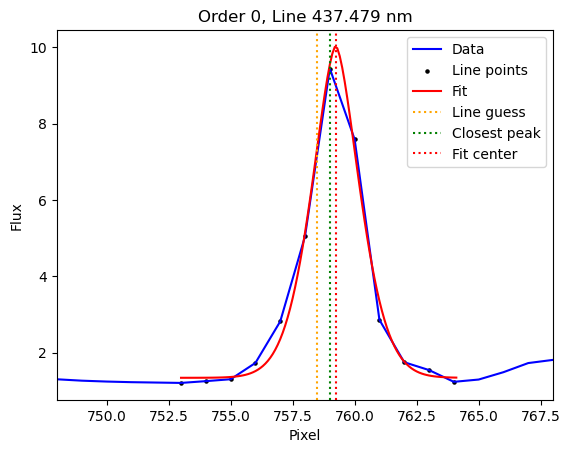

Fitting line 437.585 nm at pixel 793.75, peak height 1.27, floor 1.07


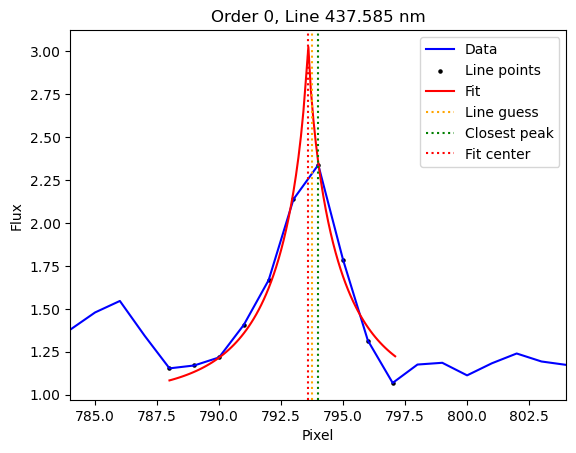

Peak height for line 437.803 nm is too low: 0.32.
Fitting line 437.818 nm at pixel 871.89, peak height 14.55, floor 1.11


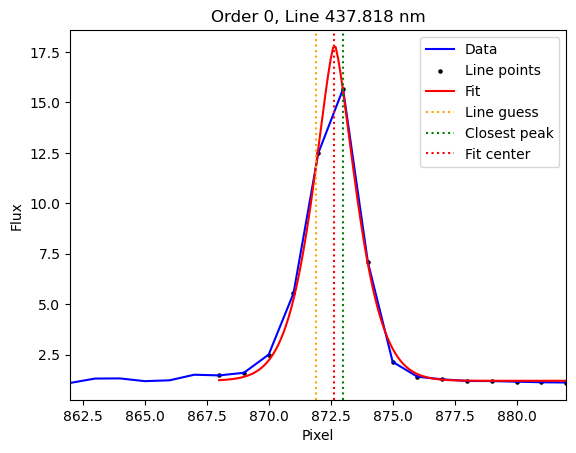

Fitting line 438.029 nm at pixel 943.43, peak height 1.18, floor 1.05


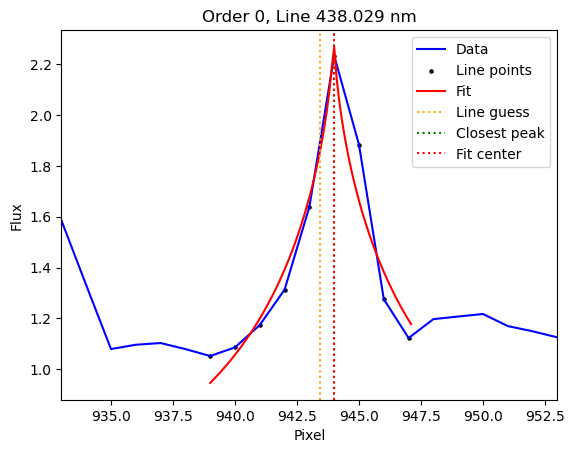

Fitting line 438.140 nm at pixel 981.58, peak height 4.59, floor 1.18


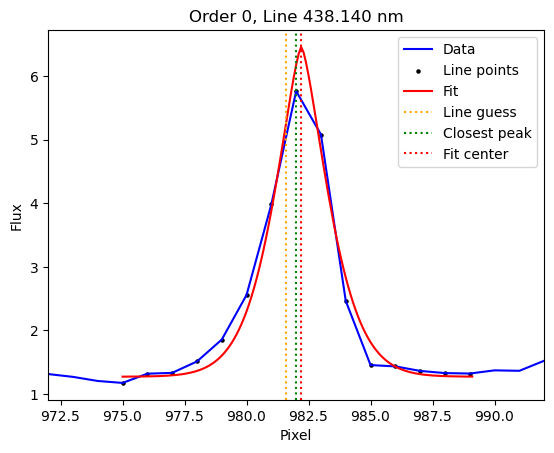

Fitting line 438.186 nm at pixel 997.33, peak height 59.98, floor 1.24


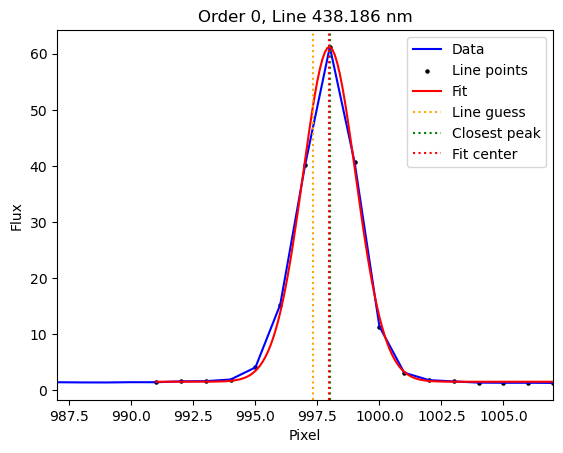

Peak height for line 438.289 nm is too low: 0.63.
Fitting line 438.466 nm at pixel 1094.22, peak height 2.58, floor 1.03


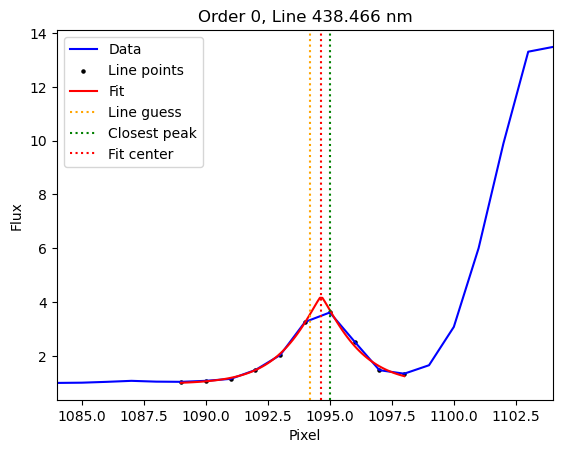

Fitting line 438.773 nm at pixel 1202.60, peak height 2.41, floor 1.00


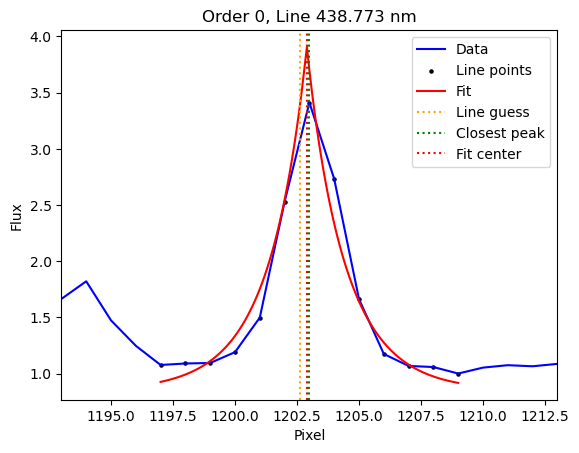

Peak for line 438.784 nm is too far from the guess pixel 1206.26.
Fitting line 439.111 nm at pixel 1323.67, peak height 84.07, floor 1.45


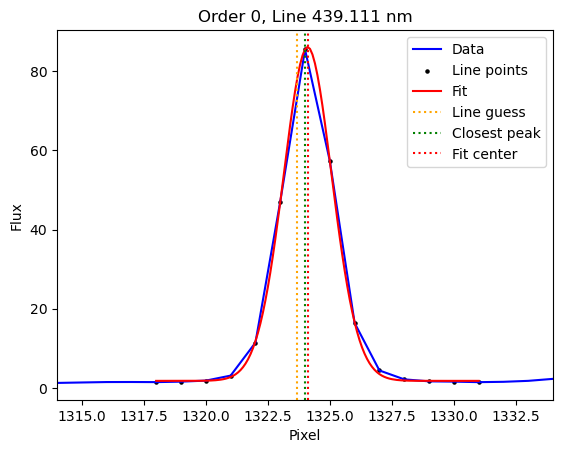

Fitting line 439.139 nm at pixel 1333.77, peak height 0.95, floor 1.33


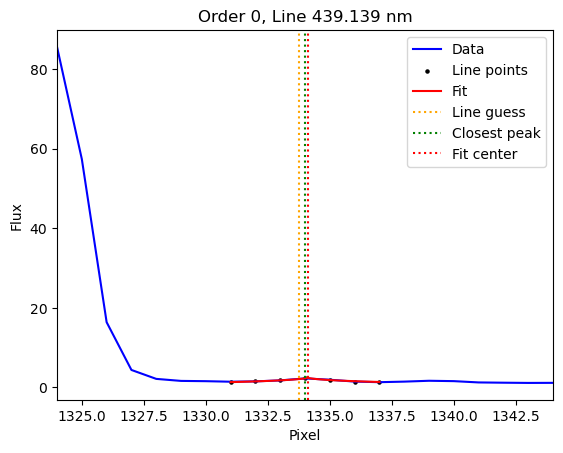

Peak height for line 439.153 nm is too low: 0.54.
Peak for line 439.297 nm is too far from the guess pixel 1391.50.
Fitting line 439.376 nm at pixel 1420.30, peak height 2.95, floor 1.09


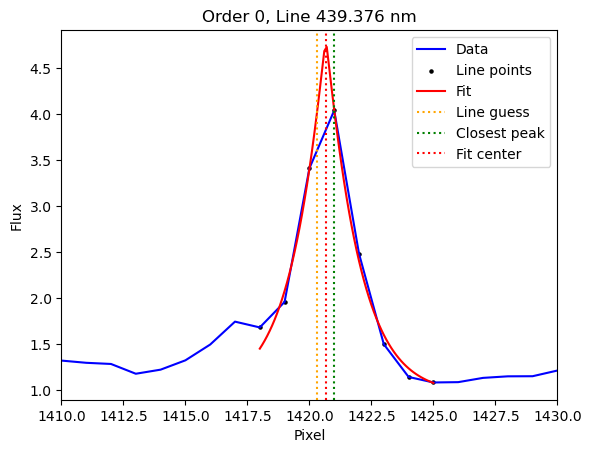

Fitting line 439.489 nm at pixel 1462.19, peak height 2.42, floor 1.11


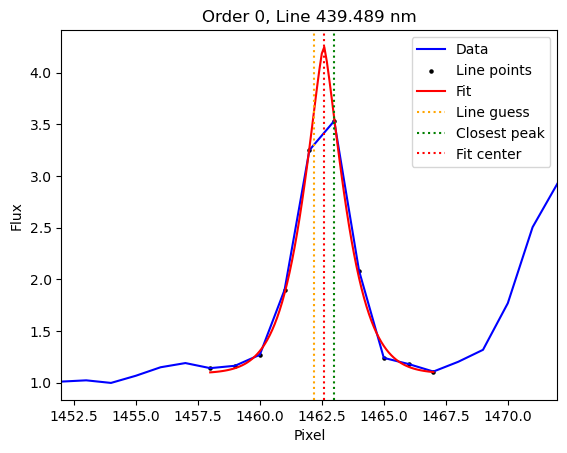

Fitting line 439.648 nm at pixel 1521.10, peak height 2.14, floor 1.02


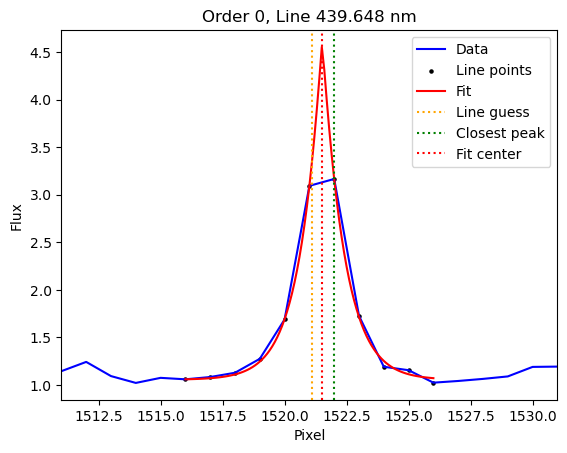

Fitting line 439.792 nm at pixel 1575.03, peak height 2.92, floor 1.03


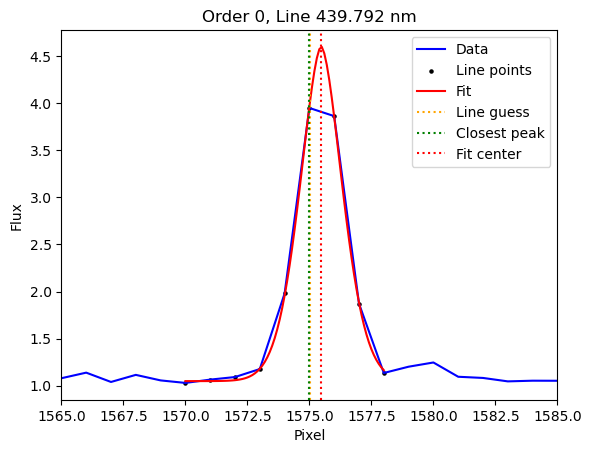

Fitting line 439.997 nm at pixel 1652.95, peak height 1.42, floor 1.08


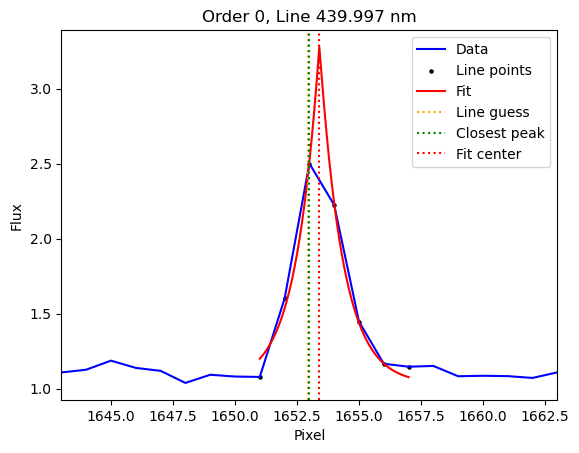

Fitting line 440.158 nm at pixel 1714.82, peak height 5.89, floor 1.13


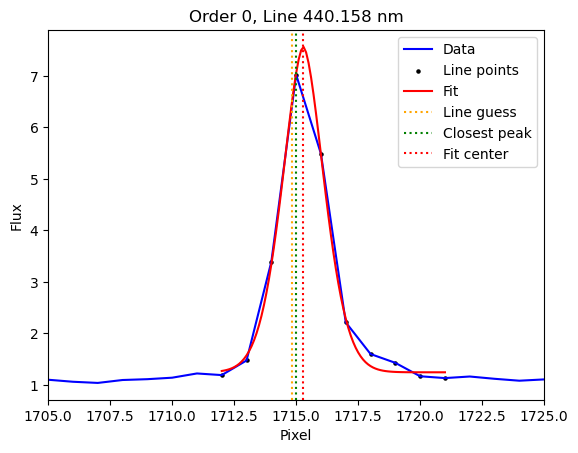

Fitting line 440.225 nm at pixel 1740.49, peak height 0.99, floor 1.03


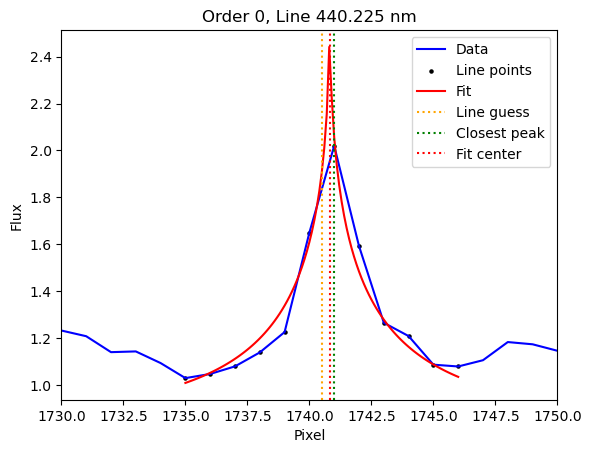

Fitting line 440.293 nm at pixel 1766.96, peak height 7.40, floor 1.17


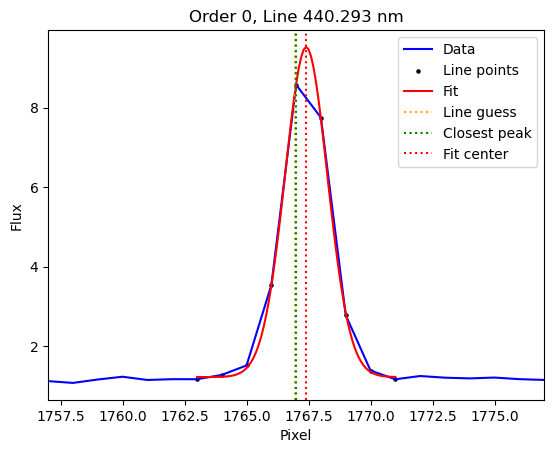

Peak height for line 440.411 nm is too low: 0.36.
Fitting line 440.848 nm at pixel 1987.11, peak height 0.76, floor 1.00


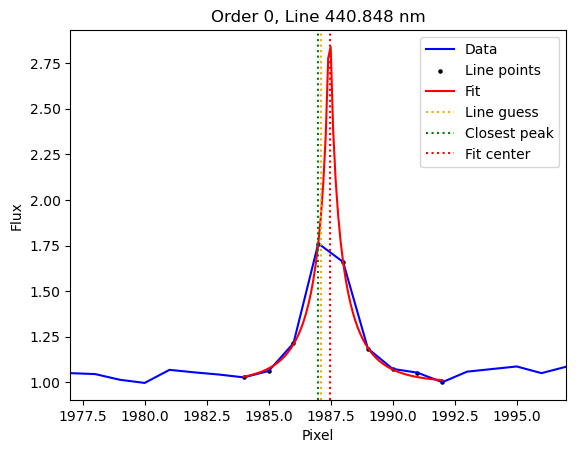

Fitting line 440.888 nm at pixel 2003.30, peak height 12.47, floor 1.03


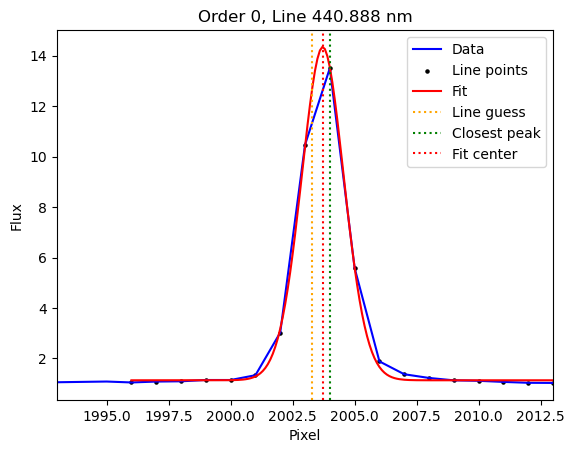

Peak height for line 440.990 nm is too low: 0.30.
Fitting line 441.253 nm at pixel 2152.83, peak height 1.10, floor 1.04


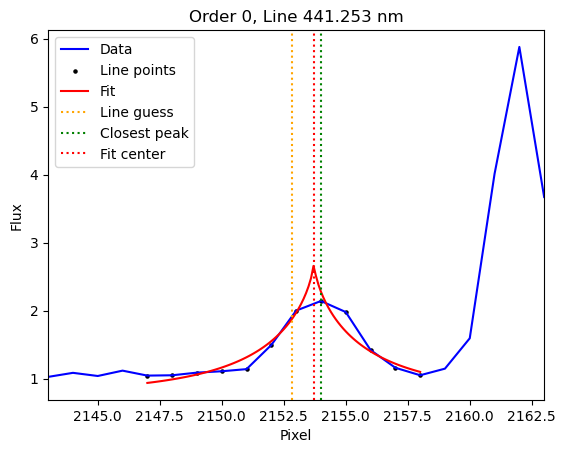

Fitting line 441.257 nm at pixel 2154.43, peak height 1.10, floor 1.04


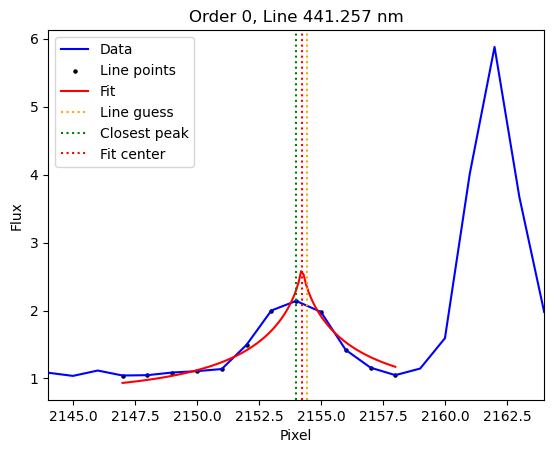

Fitting line 441.274 nm at pixel 2161.54, peak height 4.83, floor 1.05


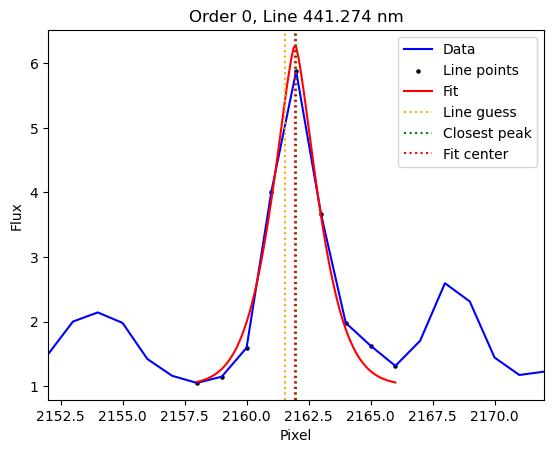

Fitting line 441.289 nm at pixel 2167.94, peak height 1.42, floor 1.17


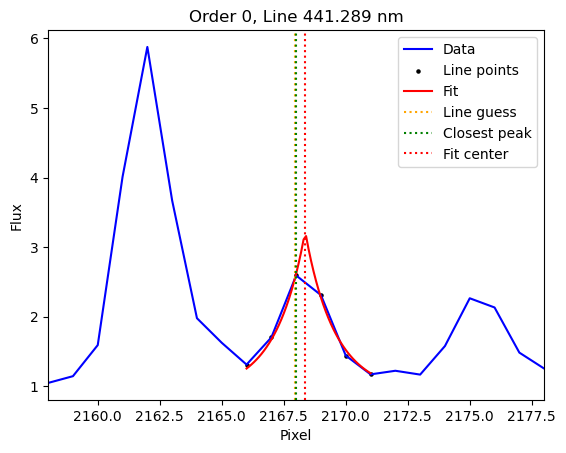

Peak height for line 441.363 nm is too low: 0.35.
Fitting line 441.449 nm at pixel 2234.67, peak height 3.18, floor 1.16


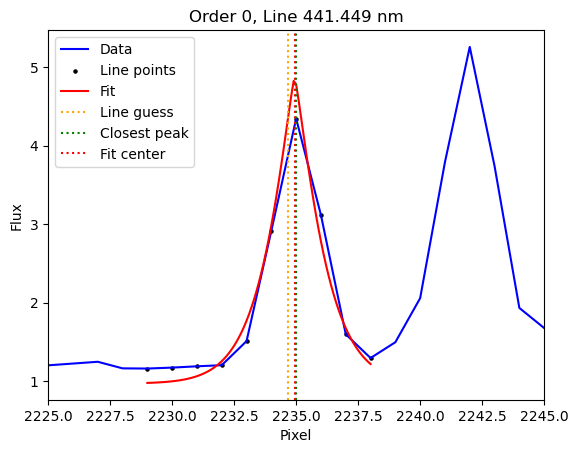

Fitting line 441.624 nm at pixel 2308.89, peak height 1.28, floor 1.14


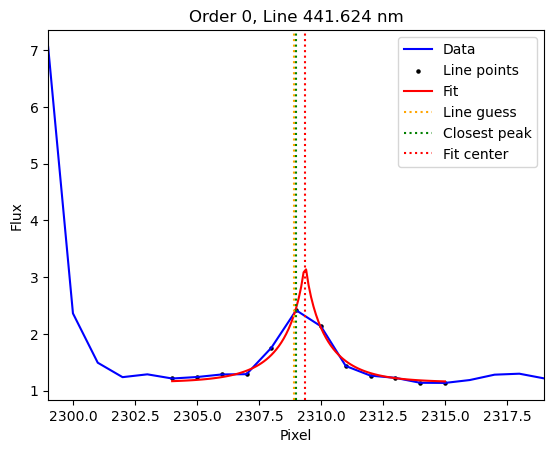

Fitting line 441.684 nm at pixel 2334.90, peak height 2.18, floor 1.17


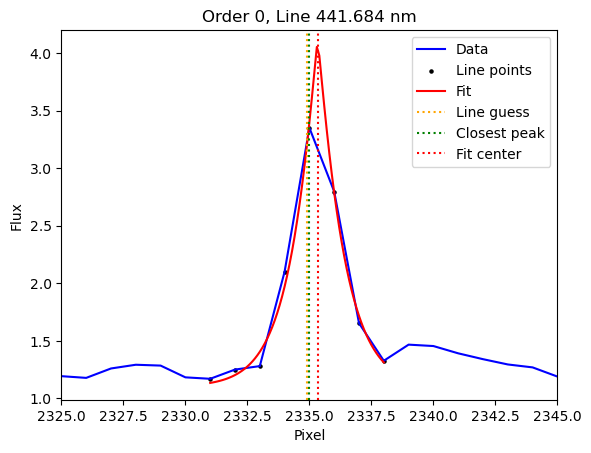

Peak height for line 442.026 nm is too low: 0.54.
Line 442.078 nm is asymmetric 0.38 - probably a blend
Fitting line 442.205 nm at pixel 2562.55, peak height 3.35, floor 1.13


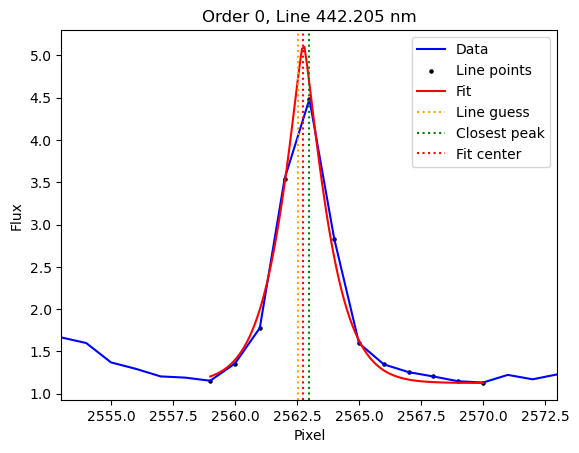

Fitting line 442.372 nm at pixel 2637.74, peak height 2.54, floor 1.26


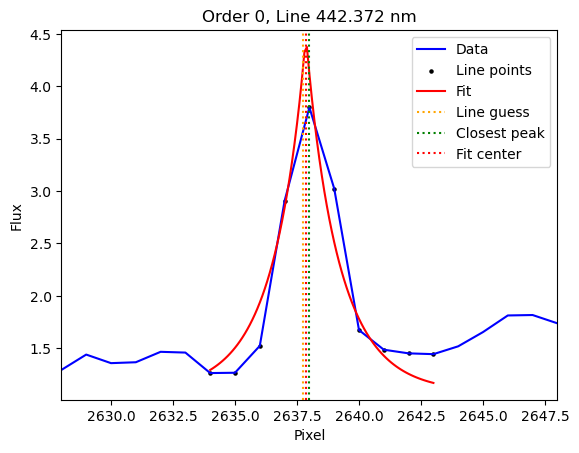

Peak height for line 442.393 nm is too low: 0.63.
Fitting line 442.484 nm at pixel 2688.57, peak height 1.37, floor 1.30


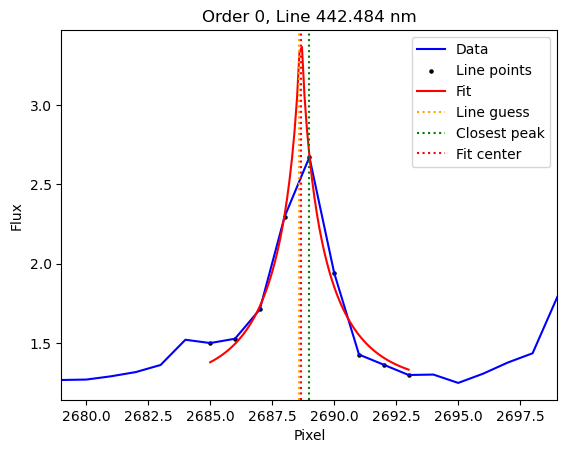

Fitting line 442.855 nm at pixel 2861.19, peak height 1.01, floor 1.22


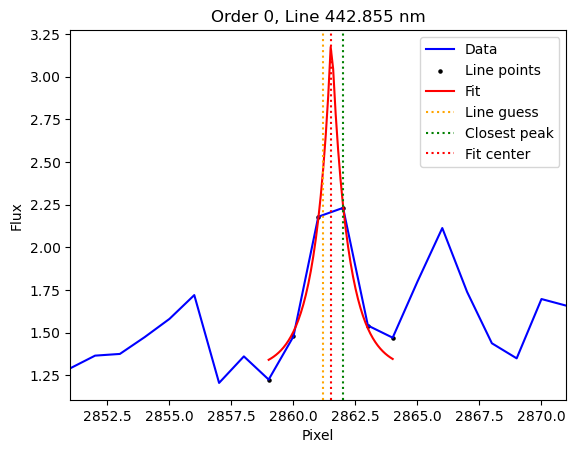

Fitting line 442.888 nm at pixel 2876.79, peak height 0.92, floor 1.04


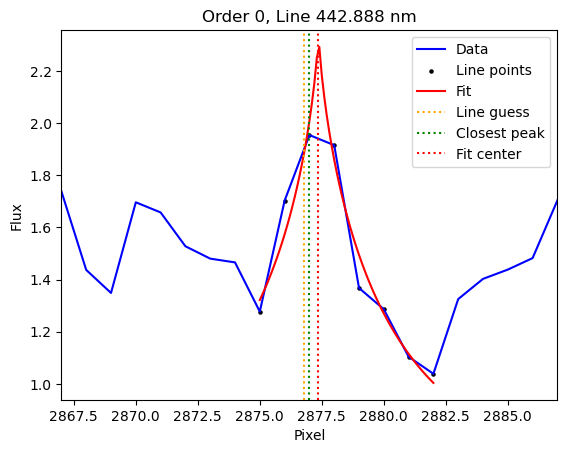

Peak height for line 442.963 nm is too low: 0.48.
Peak height for line 442.982 nm is too low: 0.53.
Fitting line 443.225 nm at pixel 3038.83, peak height 5.05, floor 1.25


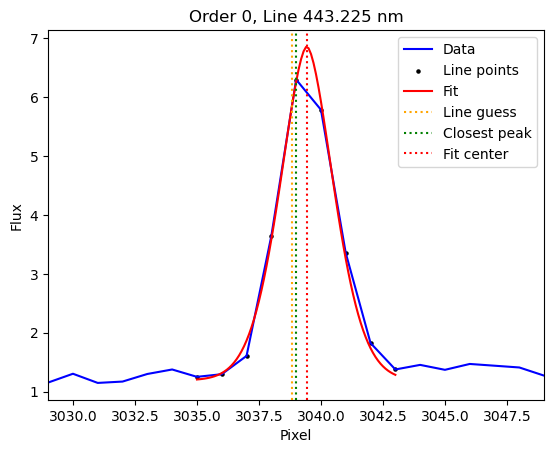

Fitting line 443.296 nm at pixel 3073.67, peak height 10.86, floor 1.42


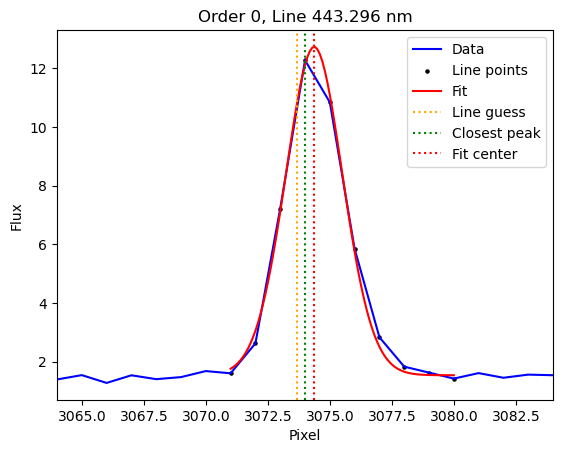

Fitting line 443.349 nm at pixel 3099.70, peak height 1.50, floor 1.21


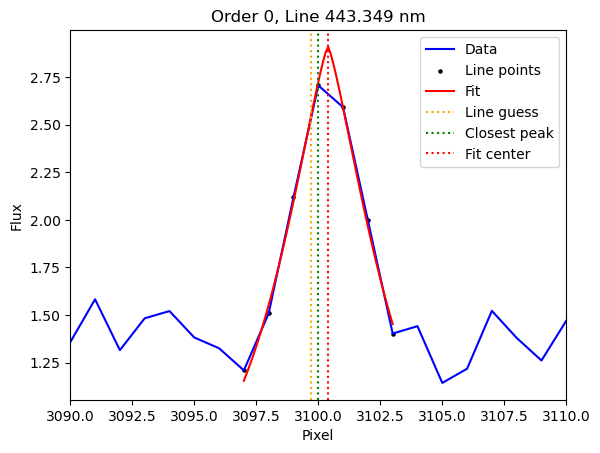

Fitting line 443.628 nm at pixel 3239.81, peak height 1.34, floor 1.31


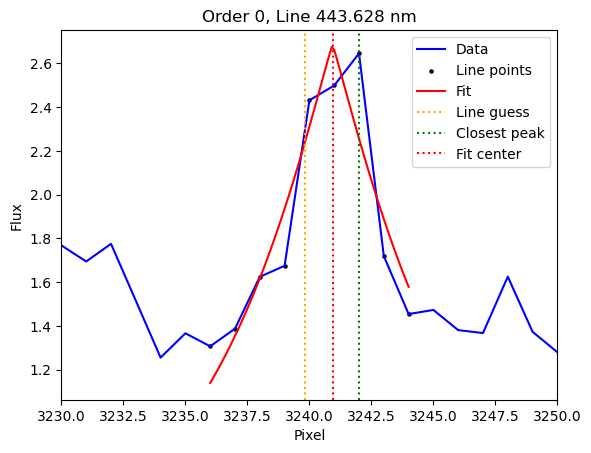

Line 443.700 nm is asymmetric 0.49 - probably a blend
Peak height for line 443.772 nm is too low: 0.47.
Fitting line 443.875 nm at pixel 3366.66, peak height 2.95, floor 1.19


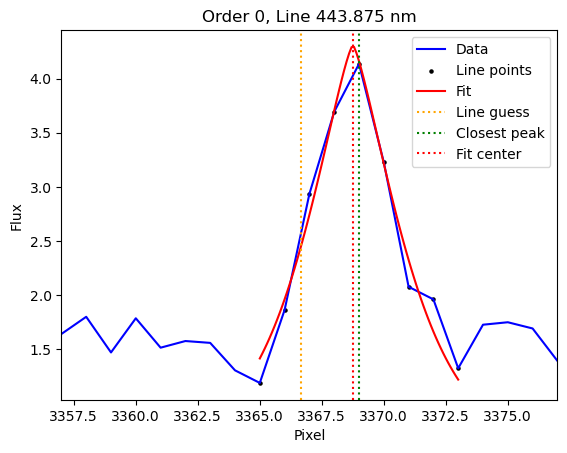

Fitting line 443.912 nm at pixel 3386.39, peak height 4.19, floor 1.48


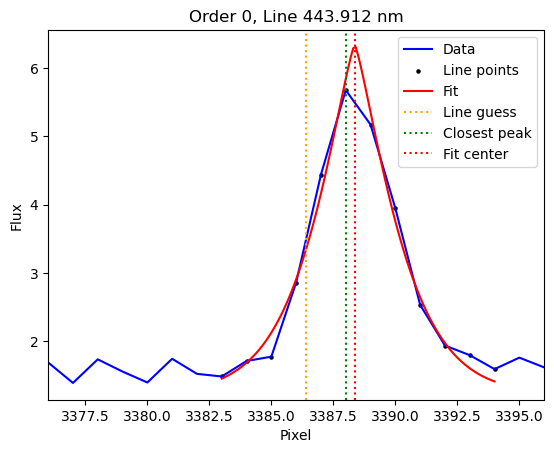

Line 444.027 nm is asymmetric 0.50 - probably a blend
Line 444.035 nm is asymmetric 0.50 - probably a blend
Peak height for line 444.057 nm is too low: 0.43.
Fitting line 444.087 nm at pixel 3478.61, peak height 12.10, floor 1.28


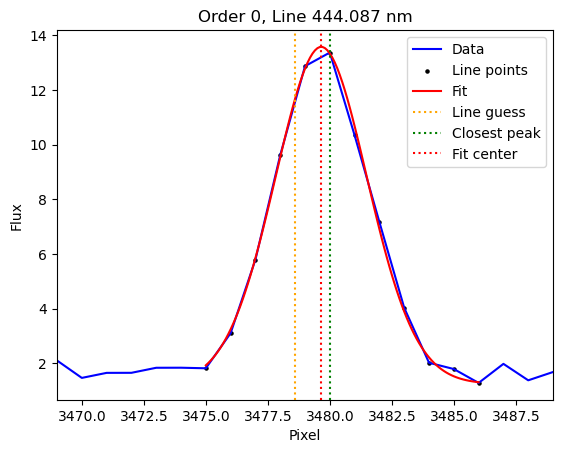

Peak for line 444.161 nm is too far from the guess pixel 3518.47.
Peak for line 444.309 nm is too far from the guess pixel 3598.83.
Peak height for line 444.367 nm is too low: 0.25.
Total lines passed: 45 out of 73


In [100]:
order = 0
# pixels = np.arange(len(extracted_ThXe[order]))
pixels = np.array(traces.y[order], dtype=int)
pixel_min, pixel_max = np.min(pixels), np.max(pixels)
wavelengths = veloce_reduction_tools.vacuum_to_air(wave[order])
if arm == 'red':
    # not normalising as very bright oversaturated lines mess with my normalisation
    flux = extracted_ThXe[order]
else:
    flux = normalise_thxe_order(extracted_ThXe[order])

lines = get_lines_in_order(wavelengths, nist_linelist, elements=['Th', 'Xe'], intensity_threshold=200, flag=['1']) # blue
# lines = get_lines_in_order(wavelengths, nist_linelist, elements=['Th', 'Xe'], intensity_threshold=200, flag=['1']) # green
# lines = get_lines_in_order(wavelengths, nist_linelist, elements=['Th', 'Xe'], intensity_threshold=100) # red
passed_mask = []
for line in lines:
    line_wave = line['obs_wl_air(nm)']
    idx = np.argmin(np.abs(wavelengths - line_wave))
    line_pixel = pixel_min + idx + (line_wave - wavelengths[idx])/(wavelengths[idx+1] - wavelengths[idx]) \
        if line_wave - wavelengths[idx] > 0 \
        else pixel_min + idx + (line_wave - wavelengths[idx])/(wavelengths[idx] - wavelengths[idx-1])

    fit_range = slice(max(0, idx-10), min(len(pixels), idx+11))
    x_fit = pixels[fit_range]
    y_fit = flux[fit_range]

    peaks, _ = find_peaks(y_fit)
    if len(peaks) == 0:
        print(f"No peaks found for line {line_wave:.3f} nm.")
        passed_mask.append(False)
        continue
    peak_idx = peaks[np.argmin(np.abs(x_fit[peaks] - (pixel_min + idx)))]
    center = x_fit[peak_idx]
    if abs(center-line_pixel) > 3:
        print(f"Peak for line {line_wave:.3f} nm is too far from the guess pixel {line_pixel:.2f}.")
        passed_mask.append(False)
        continue

    lower_bound = peak_idx-1
    while lower_bound > 1:
        if (y_fit[lower_bound] <= y_fit[lower_bound-1] and y_fit[lower_bound] <= y_fit[lower_bound+1]):
            break
        lower_bound -= 1

    upper_bound = peak_idx + 1
    while upper_bound < len(y_fit)-1:
        if (y_fit[upper_bound] <= y_fit[upper_bound-1] and y_fit[upper_bound] <= y_fit[upper_bound+1]):
            break
        upper_bound += 1

    line_floor = np.min(y_fit[lower_bound:upper_bound+1])
    peak_height = y_fit[peak_idx] - line_floor
    # if peak_height < 1: # green
    if peak_height < 0.7: # red has less lines - a bit less strict
        print(f"Peak height for line {line_wave:.3f} nm is too low: {peak_height:.2f}.")
        passed_mask.append(False)
        continue
    if (y_fit[lower_bound]-line_floor)/peak_height > 0.3 or (y_fit[upper_bound]-line_floor)/peak_height > 0.3:
        asymmetry = max((y_fit[lower_bound]-line_floor)/peak_height, (y_fit[upper_bound]-line_floor)/peak_height)
        print(f"Line {line_wave:.3f} nm is asymmetric {asymmetry:.2f} - probably a blend")
        passed_mask.append(False)
        continue
    fit_mask = np.zeros_like(y_fit, dtype=bool)
    fit_mask[lower_bound:upper_bound+1] = True
    x_fit_masked = x_fit[fit_mask]
    y_fit_masked = y_fit[fit_mask]
    if len(x_fit_masked) < 5:
        passed_mask.append(False)
        continue

    print(f"Fitting line {line_wave:.3f} nm at pixel {line_pixel:.2f}, peak height {peak_height:.2f}, floor {line_floor:.2f}")

    p0 = [y_fit[peak_idx], line_pixel, 2, 2, line_floor]
    bounds = ([0.9*y_fit[peak_idx], line_pixel-3, 1e-3, 1e-3, 0], [2*y_fit[peak_idx], line_pixel+3, 10, 10, np.max(y_fit)])
    try:
        popt, _ = curve_fit(general_gaussian, x_fit_masked, y_fit_masked, p0=p0, bounds=bounds)
        plt.plot(x_fit, y_fit, 'b-', label='Data')
        plt.scatter(x_fit_masked, y_fit_masked, c='k', s=5, label='Line points')
        x_fine = np.arange(x_fit_masked.min(), x_fit_masked.max()+0.1, 0.1)
        plt.plot(x_fine, general_gaussian(x_fine, *popt), 'r-', label='Fit')
        plt.axvline(line_pixel, c='orange', ls=':', label='Line guess')
        plt.axvline(center, c='green', ls=':', label='Closest peak')
        plt.axvline(popt[1], c='red', ls=':', label='Fit center')
        plt.title(f"Order {order}, Line {line_wave:.3f} nm")
        plt.xlim(x_fit.min(), x_fit.max())
        # plt.ylim(min(0.7, y_fit.min()*0.9), general_gaussian(x_fine, *popt).max()*1.1)
        plt.xlabel('Pixel')
        plt.ylabel('Flux')
        plt.legend()
        plt.show()
        passed_mask.append(True)
    except Exception as e:
        print(f"Fit failed for line {line_wave:.3f} nm: {e}")
        passed_mask.append(False)
passed_mask = np.array(passed_mask)
print(f"Total lines passed: {np.sum(passed_mask)} out of {len(lines)}")

##### Fit all lines

In [101]:
# order = 20
# pixels = np.arange(len(extracted_ThXe[order]))
# wavelengths = veloce_reduction_tools.vacuum_to_air(wave[order])
# flux = normalise_thxe_order(extracted_ThXe[order])

def fit_lines_in_order(wavelengths, flux, pixels, linelist, arm, plot=False):
    """
    Fit lines in the order using the provided linelist.
    """
    ### need different conditions for each arm
    if arm == 'green':
        lines = get_lines_in_order(wavelengths, linelist, elements=['Th', 'Xe'], intensity_threshold=200, flag=['1'])
        peak_height_threshold = 1.0
        peak_asymmetry_threshold = 0.4
        peak_position_threshold = 3.0
    elif arm == 'red':
        lines = get_lines_in_order(wavelengths, linelist, elements=['Th', 'Xe'], intensity_threshold=100)
        peak_height_threshold = 0.3
        peak_asymmetry_threshold = 0.5
        peak_position_threshold = 4.0
    elif arm == 'blue':
        # TODO implement blue arm conditions
        # For now, using similar conditions as for green arm
        lines = get_lines_in_order(wavelengths, linelist, elements=['Th', 'Xe'], intensity_threshold=200, flag=['1'])
        peak_height_threshold = 0.7
        peak_asymmetry_threshold = 0.3
        peak_position_threshold = 3.0
    else:
        raise ValueError(f"Unknown arm: {arm}. Supported arms are 'green', 'red', and 'blue'.")
    
    pixels = np.array(pixels, dtype=np.int_)
    min_pixel, max_pixel = np.min(pixels), np.max(pixels)
    passed_mask = []
    lines_pixel_positions = []
    lines_wave_positions = []
    for line in lines:
        line_wave = line['obs_wl_air(nm)']
        idx = np.argmin(np.abs(wavelengths - line_wave))
        line_pixel = min_pixel + idx + (line_wave - wavelengths[idx])/(wavelengths[idx+1] - wavelengths[idx]) \
            if line_wave - wavelengths[idx] > 0 \
            else min_pixel + idx + (line_wave - wavelengths[idx])/(wavelengths[idx] - wavelengths[idx-1])

        fit_range = slice(max(0, idx-10), min(len(pixels), idx+11))
        x_fit = pixels[fit_range]
        y_fit = flux[fit_range]

        peaks, _ = find_peaks(y_fit)
        if len(peaks) == 0:
            print(f"No peaks found for line {line_wave:.3f} nm.")
            passed_mask.append(False)
            continue
        peak_idx = peaks[np.argmin(np.abs(x_fit[peaks] - (min_pixel + idx)))]
        center = x_fit[peak_idx]
        if abs(center-line_pixel) > peak_position_threshold:
            print(f"Peak {center} for line {line_wave:.3f} nm is too far from the guess pixel {line_pixel:.2f}.")
            if line_wave - wavelengths[idx] > 0:
                print((line_wave - wavelengths[idx])/(wavelengths[idx+1] - wavelengths[idx]))
            else:
                print((line_wave - wavelengths[idx])/(wavelengths[idx] - wavelengths[idx-1]))
            passed_mask.append(False)
            continue

        lower_bound = peak_idx-1
        while lower_bound > 1:
            if (y_fit[lower_bound] <= y_fit[lower_bound-1] and y_fit[lower_bound] <= y_fit[lower_bound+1]):
                break
            lower_bound -= 1

        upper_bound = peak_idx + 1
        while upper_bound < len(y_fit)-1:
            if (y_fit[upper_bound] <= y_fit[upper_bound-1] and y_fit[upper_bound] <= y_fit[upper_bound+1]):
                break
            upper_bound += 1

        line_floor = np.min(y_fit[lower_bound:upper_bound+1])
        peak_height = y_fit[peak_idx] - line_floor
        if peak_height < peak_height_threshold:
            print(f"Peak height for line {line_wave:.3f} nm is too low: {peak_height:.2f}.")
            passed_mask.append(False)
            continue
        if (y_fit[lower_bound]-line_floor)/peak_height > peak_asymmetry_threshold or (y_fit[upper_bound]-line_floor)/peak_height > peak_asymmetry_threshold:
            print(f"Line {line_wave:.3f} nm is asymmetric - probably a blend")
            passed_mask.append(False)
            continue
        fit_mask = np.zeros_like(y_fit, dtype=bool)
        fit_mask[lower_bound:upper_bound+1] = True
        x_fit_masked = x_fit[fit_mask]
        y_fit_masked = y_fit[fit_mask]
        if len(x_fit_masked) < 5: # Not enough points to fit
            passed_mask.append(False)
            continue

        print(f"Fitting line {line_wave:.3f} nm at pixel {line_pixel:.2f}, peak height {peak_height:.2f}, floor {line_floor:.2f}")

        p0 = [y_fit[peak_idx], line_pixel, 2, 2, line_floor]
        bounds = ([0.9*y_fit[peak_idx], line_pixel-3, 1e-3, 1e-3, 0], [2*y_fit[peak_idx], line_pixel+3, 10, 10, np.max(y_fit)])
        try:
            popt, _ = curve_fit(general_gaussian, x_fit_masked, y_fit_masked, p0=p0, bounds=bounds)
            if plot:
                plt.plot(x_fit, y_fit, 'b-', label='Data')
                plt.scatter(x_fit_masked, y_fit_masked, c='k', s=5, label='Line points')
                x_fine = np.arange(x_fit_masked.min(), x_fit_masked.max()+0.1, 0.1)
                plt.plot(x_fine, general_gaussian(x_fine, *popt), 'r-', label='Fit')
                plt.axvline(line_pixel, c='orange', ls=':', label='Line guess')
                plt.axvline(center, c='green', ls=':', label='Closest peak')
                plt.axvline(popt[1], c='red', ls=':', label='Fit center')
                plt.title(f"Order {order}, Line {line_wave:.3f} nm")
                plt.xlim(x_fit.min(), x_fit.max())
                plt.ylim(min(0.7, y_fit.min()*0.9), general_gaussian(x_fine, *popt).max()*1.1)
                plt.xlabel('Pixel')
                plt.ylabel('Flux')
                plt.legend()
                plt.show()
            passed_mask.append(True)
            lines_pixel_positions.append(popt[1])
            lines_wave_positions.append(line_wave)
        except Exception as e:
            print(f"Fit failed for line {line_wave:.3f} nm: {e}")
            passed_mask.append(False)
    
    passed_mask = np.array(passed_mask)
    print(f"Total lines passed: {np.sum(passed_mask)} out of {len(lines)}")
    return np.array(lines_pixel_positions), np.array(lines_wave_positions), lines[passed_mask]

In [102]:
pixel_positions, wave_positions, order_positions = [], [], []
for order, absolute_order in enumerate(ORDER):
    print(f"Fitting lines in order {absolute_order} ({order})")
    if arm == 'red':
        # not normalising as very bright oversaturated lines mess with my normalisation
        lines_pixel_positions, lines_wave_positions, fitted_lines = fit_lines_in_order(
                veloce_reduction_tools.vacuum_to_air(wave[order]),
                extracted_ThXe[order],
                traces.y[order],
                nist_linelist, arm, plot=False)
    elif arm == 'green':
        lines_pixel_positions, lines_wave_positions, fitted_lines = fit_lines_in_order(
            veloce_reduction_tools.vacuum_to_air(wave[order]),
            normalise_thxe_order(extracted_ThXe[order]),
            traces.y[order],
            nist_linelist, arm, plot=False)
    else: # blue
        lines_pixel_positions, lines_wave_positions, fitted_lines = fit_lines_in_order(
            veloce_reduction_tools.vacuum_to_air(wave[order]),
            normalise_thxe_order(extracted_ThXe[order], nknots=50),
            traces.y[order],
            nist_linelist, arm, plot=False)
    lines_order_positions = np.ones_like(lines_pixel_positions) * absolute_order
    pixel_positions.append(lines_pixel_positions)
    wave_positions.append(lines_wave_positions)
    order_positions.append(lines_order_positions)
pixel_positions = np.concatenate(pixel_positions)
wave_positions = np.concatenate(wave_positions)
order_positions = np.concatenate(order_positions)

Fitting lines in order 139 (0)
Found 73 lines in the order.
Fitting line 435.937 nm at pixel 266.44, peak height 5.08, floor 1.21
Fitting line 436.017 nm at pixel 290.95, peak height 1.06, floor 1.28
Peak height for line 436.247 nm is too low: 0.58.
Fitting line 436.593 nm at pixel 471.34, peak height 11.32, floor 1.13
Peak height for line 436.729 nm is too low: 0.66.
Line 436.742 nm is asymmetric - probably a blend
Line 436.929 nm is asymmetric - probably a blend
Fitting line 436.949 nm at pixel 585.43, peak height 2.73, floor 1.26
Fitting line 436.988 nm at pixel 597.75, peak height 6.40, floor 1.16
Line 437.304 nm is asymmetric - probably a blend
Line 437.390 nm is asymmetric - probably a blend
Line 437.401 nm is asymmetric - probably a blend
Fitting line 437.412 nm at pixel 736.60, peak height 25.41, floor 1.32
Fitting line 437.479 nm at pixel 758.48, peak height 8.26, floor 1.21
Fitting line 437.585 nm at pixel 793.75, peak height 1.27, floor 1.06
Peak height for line 437.803 nm i

/home/usqobserver2/anaconda3/envs/reduce_spectro/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Fitting line 434.225 nm at pixel 3228.18, peak height 7.66, floor 1.18
Fitting line 434.244 nm at pixel 3238.03, peak height 23.60, floor 1.29
Fitting line 434.338 nm at pixel 3287.07, peak height 1.71, floor 1.16
Fitting line 434.395 nm at pixel 3317.12, peak height 12.69, floor 1.10
Fitting line 434.433 nm at pixel 3337.01, peak height 25.63, floor 1.12
Fitting line 434.564 nm at pixel 3407.08, peak height 1.36, floor 1.12
Fitting line 434.585 nm at pixel 3418.75, peak height 2.55, floor 1.21
Fitting line 434.641 nm at pixel 3449.24, peak height 18.89, floor 1.22
Fitting line 434.644 nm at pixel 3450.52, peak height 18.89, floor 1.22
Fitting line 434.860 nm at pixel 3569.79, peak height 4.02, floor 1.01
Fitting line 434.907 nm at pixel 3596.37, peak height 11.59, floor 1.12
Fitting line 435.027 nm at pixel 3664.36, peak height 1.59, floor 1.17
Total lines passed: 86 out of 98
Fitting lines in order 143 (4)
Found 87 lines in the order.
Fitting line 424.059 nm at pixel 373.81, peak hei

### Fit wavelength solution

In [103]:
# extracted_pixels = [np.arange(len(extracted_ThXe[order])) for order in range(len(extracted_ThXe))]
max_extracted_pixel = max([max(trace_y) for trace_y in traces.y])
min_extracted_pixel = min([min(trace_y) for trace_y in traces.y])
full_pixels = np.array([np.arange(min_extracted_pixel, max_extracted_pixel + 1) for _ in range(len(extracted_ThXe))])
# extracted_pixels = pad_array(extracted_pixels, full_pixels)

##### Wave solution fitting functions

In [104]:
# def fit_surface(dispersion_position, orders_position, wave_array, extracted_pixels, degree=1):
#     """
#     Fit a surface to the offset map using least squares.

#     Fitting procedure inspired by: https://gist.github.com/amroamroamro/1db8d69b4b65e8bc66a6
#     """

#     data = np.array([(x, y, z) for x, y, z in zip(dispersion_position, orders_position, wave_array*orders_position)])
#     # data = np.array([(x, y, z) for x, y, z in zip(dispersion_position, orders_position, wave_array)])

#     grid_points = [[(pixel, abs_order) for pixel in extracted_pixels[i]] for i, abs_order in enumerate(np.unique(orders_position))]
#     grid_points = np.vstack(grid_points)

#     # Perform iterative sigma clipping around the fitted surface
#     max_iterations = 10
#     sigma_threshold = 3.0
#     mask = np.ones(data.shape[0], dtype=bool)
#     mask *= ~np.isnan(data[:, 2]) 
#     for _ in range(max_iterations):
#         if degree == 1:
#             A = np.c_[data[mask, 0], data[mask, 1], np.ones(data[mask].shape[0])]
#         elif degree == 2:
#             A = np.c_[data[mask, 0]**2, data[mask, 1]**2, data[mask, 0]*data[mask, 1], data[mask, 0], data[mask, 1], np.ones(data[mask].shape[0])]
#         elif degree == 3:
#             A = np.c_[data[mask, 0]**3, data[mask, 1]**3, data[mask, 0]**2 * data[mask, 1], data[mask, 0] * data[mask, 1]**2,
#                       data[mask, 0]**2, data[mask, 1]**2, data[mask, 0]*data[mask, 1], data[mask, 0], data[mask, 1], np.ones(data[mask].shape[0])]
#         else:
#             raise ValueError("Only polynomial orders 1, 2, or 3 are supported.")
        
#         C, _, _, _ = lstsq(A, data[mask, 2])

#         if degree == 1:
#             residuals = data[:, 2] - (C[0] * data[:, 0] + C[1] * data[:, 1] + C[2])
#         elif degree == 2:
#             residuals = data[:, 2] - (C[0] * data[:, 0]**2 + C[1] * data[:, 1]**2 + C[2] * data[:, 0] * data[:, 1] +
#              C[3] * data[:, 0] + C[4] * data[:, 1] + C[5])
#         elif degree == 3:
#             residuals = data[:, 2] - (C[0] * data[:, 0]**3 + C[1] * data[:, 1]**3 + C[2] * data[:, 0]**2 * data[:, 1] +
#              C[3] * data[:, 0] * data[:, 1]**2 + C[4] * data[:, 0]**2 + C[5] * data[:, 1]**2 +
#              C[6] * data[:, 0] * data[:, 1] + C[7] * data[:, 0] + C[8] * data[:, 1] + C[9])
            
#         std_dev = np.std(residuals[mask])
#         new_mask = np.abs(residuals) < sigma_threshold * std_dev
#         if np.array_equal(mask, new_mask):
#             break

#         mask = new_mask

#     print(f"Fitted coefficients: {C}")

#     # Evaluate for each pixel
#     if degree == 1:
#         z = [C[0]*x + C[1]*y + C[2] for x, y in grid_points]
#     elif degree == 2:
#         z = [C[0]*x**2 + C[1]*y**2 + C[2]*x*y + C[3]*x + C[4]*y + C[5] for x, y in grid_points]
#     elif degree == 3:
#         z = [C[0]*x**3 + C[1]*y**3 + C[2]*x**2*y + C[3]*x*y**2 + C[4]*x**2 + C[5]*y**2 +
#              C[6]*x*y + C[7]*x + C[8]*y + C[9] for x, y in grid_points]

#     Z = np.array(z).reshape(extracted_pixels.shape)

#     # if plot:
#     #     veloce_diagnostic.plot_surface(np.unique(orders_position), extracted_pixels, Z, data[mask],
#     #                                    veloce_paths=veloce_paths, filename=filename)

#     return Z, C, data[mask], residuals[mask]

In [105]:
def fit_surface_custom(dispersion_position, orders_position, wave_array, extracted_pixels, degree=3, sigma_clip=3.0):
    """
    Fit a surface to the offset map using least squares.
    Generalized to 2D polynomial with dependent degree in x and y.
    """

    # Prepare data: z = wave_array * orders_position
    data = np.array([(x, y, z) for x, y, z in zip(dispersion_position, orders_position, wave_array * orders_position)])

    # Generate all monomial powers for 2D polynomial up to degree_x and degree_y
    def monomial_powers_2d(degree):
        return [(i, j) for i in range(degree + 1) for j in range(degree - i + 1)]

    powers = monomial_powers_2d(degree)
    print(f"Using polynomial powers: {powers}")

    # Build design matrix
    def build_design_matrix(x, y, powers):
        return np.stack([x**i * y**j for i, j in powers], axis=-1)

    # Sigma clipping fit
    max_iterations = 1000
    mask = ~np.isnan(data[:, 2])
    for iteration in range(max_iterations):
        A = build_design_matrix(data[mask, 0], data[mask, 1], powers)
        C, _, _, _ = lstsq(A, data[mask, 2])
        residuals = data[:, 2] - build_design_matrix(data[:, 0], data[:, 1], powers) @ C
        std_dev = np.std(residuals[mask])
        new_mask = np.abs(residuals) < sigma_clip * std_dev
        if np.array_equal(mask, new_mask):
            print(f"Converged after {iteration} iterations.")
            break
        mask = new_mask
    print(iteration)
    print(C)

    # Evaluate surface on grid
    grid_points = np.vstack([(pixel, abs_order) for i, abs_order in enumerate(np.unique(orders_position)) for pixel in extracted_pixels[i]])
    Z = build_design_matrix(grid_points[:, 0], grid_points[:, 1], powers) @ C
    print(f"Fitted surface shape: {Z.shape}, {build_design_matrix(grid_points[:, 0], grid_points[:, 1], powers).shape}, {C.shape}")
    Z = Z.reshape(len(extracted_pixels), -1)

    return Z, C, data, residuals, mask


In [106]:
# def fit_surface_sklearn(dispersion_position, orders_position, wave_array, extracted_pixels, degree=3, sigma_clip=3.0, seed=None):
#     """
#     Fit a bivariate polynomial surface to the wavelength solution using RANSAC for outlier rejection.
#     Returns fitted surface, residuals, and inlier mask.
#     """
#     # Prepare data
#     x = dispersion_position
#     y = orders_position
#     y_fit = wave_array * orders_position  
#     # y_fit = wave_array

#     grid_points = np.vstack([(pixel, abs_order) for i, abs_order in enumerate(np.unique(orders_position)) for pixel in extracted_pixels[i]])

#     # Use scikit-learn PolynomialFeatures + Ridge for surface fitting
#     X = np.column_stack([x, y])
#     poly = PolynomialFeatures(degree=degree)
#     ridge = Ridge(alpha=1.0)
#     model = make_pipeline(poly, ridge)

#     # scale = StandardScaler()
#     # model = make_pipeline(poly, scale, ridge)
#     # model = Pipeline([('poly', poly), ('scale', scale), ('ridge', ridge)])

#     # Fit the model to get initial residuals
#     # X_poly = poly.fit_transform(X)
#     model.fit(X, y_fit)
#     residuals = y_fit - model.predict(X)
#     print(np.std(residuals))

#     # Use RANSAC for robust fitting
#     if seed is None:
#         ransac = RANSACRegressor(model, min_samples=0.75, residual_threshold=sigma_clip*np.std(residuals))
#     else:
#         ransac = RANSACRegressor(model, min_samples=0.75, residual_threshold=sigma_clip*np.std(residuals), random_state=seed)
#     ransac.fit(X, y_fit)
#     inlier_mask = ransac.inlier_mask_

#     # Predict on grid
#     Z = ransac.predict(grid_points).reshape(extracted_pixels.shape)
#     residuals = y_fit - ransac.predict(X)

#     return Z, residuals, inlier_mask


In [143]:
def fit_surface_sklearn(dispersion_position, orders_position, wave_array, extracted_pixels, degree=3, sigma_clip=3.0, robust=False, seed=None):
    """
    Fit a bivariate polynomial surface to the wavelength solution using RANSAC for outlier rejection.
    Returns fitted surface, residuals, and inlier mask.
    """
    # Prepare data
    x = dispersion_position
    y = orders_position
    y_fit = wave_array * orders_position  
    # y_fit = wave_array

    grid_points = np.vstack([(pixel, abs_order) for i, abs_order in enumerate(np.unique(orders_position)) for pixel in extracted_pixels[i]])

    # Use scikit-learn PolynomialFeatures + Ridge for surface fitting
    X = np.column_stack([x, y])
    poly = PolynomialFeatures(degree=degree)
    ridge = Ridge(alpha=1.0)
    model = make_pipeline(poly, ridge)

    # scale = StandardScaler()
    # model = make_pipeline(poly, scale, ridge)
    # model = Pipeline([('poly', poly), ('scale', scale), ('ridge', ridge)])

    # Fit the model to get initial residuals
    # X_poly = poly.fit_transform(X)
    
    model.fit(X, y_fit)
    residuals = y_fit - model.predict(X)
    init_residuals_std = np.std(residuals)
    
    max_iterations = 100
    mask = residuals < sigma_clip * np.std(residuals)
    for iteration in range(max_iterations):
        model.fit(X[mask], y_fit[mask])
        residuals = y_fit - model.predict(X)
        std_dev = np.std(residuals[mask])
        new_mask = np.abs(residuals) < sigma_clip * std_dev
        if np.array_equal(mask, new_mask):
            print(f"Converged.")
            break
        mask = new_mask
    print(f"Std of residuals droped from {init_residuals_std:.3f} to {std_dev:.3f} after {iteration} iterations.")

    if robust:
        # Use RANSAC for robust fitting on the final mask
        if seed is None:
            ransac = RANSACRegressor(model, min_samples=0.5, residual_threshold=sigma_clip*std_dev)
        else:
            ransac = RANSACRegressor(model, min_samples=0.5, residual_threshold=sigma_clip*std_dev, random_state=seed)
        ransac.fit(X, y_fit)
        inlier_mask = ransac.inlier_mask_

        # compare inlier mask with the previous mask
        print(f"RANSAC inliers: {np.sum(inlier_mask)} vs iterative outlier rejection {np.sum(mask)}")
        if not np.array_equal(mask, inlier_mask):
            print("Warning: Inlier mask from RANSAC does not match the previous mask. This may indicate that RANSAC found a different set of inliers.")
        
        # Predict on grid
        Z = ransac.predict(grid_points).reshape(extracted_pixels.shape)
        residuals = y_fit - ransac.predict(X)
        mask = inlier_mask
        model = ransac
    else:
        Z = model.predict(grid_points).reshape(extracted_pixels.shape)
        residuals = y_fit - model.predict(X)

    return Z, residuals, mask, model

In [108]:
def fit_polynomial_per_order(pixel_positions, order_positions, wave_positions, degree=2, sigma_clip=3.0, max_iter=10):
    """
    Fit a polynomial of given degree for each order separately with outlier rejection.
    Returns a dict: {order: (numpy.poly1d object, coeff_uncertainties)}
    """
    unique_orders = np.unique(order_positions)
    polynomials = {}
    for order in unique_orders:
        mask = order_positions == order
        x = pixel_positions[mask]
        y = wave_positions[mask]
        inlier_mask = np.ones_like(x, dtype=bool)
        for _ in range(max_iter):
            coeffs, cov = np.polyfit(x[inlier_mask], y[inlier_mask], degree, cov=True)
            y_fit = np.polyval(coeffs, x)
            residuals = y - y_fit
            std_dev = np.std(residuals[inlier_mask])
            new_mask = np.abs(residuals) < sigma_clip * std_dev
            if np.array_equal(inlier_mask, new_mask):
                break
            inlier_mask = new_mask
        # uncertainties = np.sqrt(np.diag(cov))
        polynomials[order] = (np.poly1d(coeffs), residuals, inlier_mask)
    return polynomials

##### Fit wave solution surface or individual polynomials

In [ ]:
# Z, C, fitted_points, residuals, mask = fit_surface_custom(pixel_positions, order_positions, wave_positions, full_pixels, degree=3)

Using polynomial powers: [(0, 0), (0, 1), (0, 2), (0, 3), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (3, 0)]
Converged after 16 iterations.
16
[ 6.02363785e+04  4.78242694e+00 -2.83165651e-02  1.86759790e-05
  5.50661325e-01 -1.87977431e-03  1.07234450e-05 -2.57671032e-05
 -8.52296443e-08  9.75196189e-10]
Fitted surface shape: (152456,), (152456, 10), (10,)


In [144]:
# Z, residuals, mask = fit_surface_sklearn(pixel_positions, order_positions, wave_positions, full_pixels, degree=5, sigma_clip=3, robust=True, seed=42)
# Z, residuals, mask = fit_surface_sklearn(pixel_positions, order_positions, wave_positions, full_pixels, degree=7, sigma_clip=3, robust=False, seed=42)
# Z, residuals, mask = fit_surface_sklearn(pixel_positions, order_positions, wave_positions, full_pixels, degree=7, sigma_clip=2.5, robust=True, seed=42) # red?
Z, residuals, mask, model = fit_surface_sklearn(pixel_positions, order_positions, wave_positions, full_pixels, degree=5, sigma_clip=2.5, robust=True, seed=42)

/home/usqobserver2/anaconda3/envs/reduce_spectro/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning: Ill-conditioned matrix (rcond=2.76495e-38): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/usqobserver2/anaconda3/envs/reduce_spectro/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning: Ill-conditioned matrix (rcond=2.79171e-38): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/usqobserver2/anaconda3/envs/reduce_spectro/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning: Ill-conditioned matrix (rcond=2.92331e-38): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/usqobserver2/anaconda3/envs/reduce_spectro/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning: Ill-conditioned matrix (rcond=3.12158e-38): result may not be accurate.
 

Converged.
Std of residuals droped from 0.241 to 0.032 after 14 iterations.


/home/usqobserver2/anaconda3/envs/reduce_spectro/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning: Ill-conditioned matrix (rcond=5.0485e-38): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/usqobserver2/anaconda3/envs/reduce_spectro/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning: Ill-conditioned matrix (rcond=5.50829e-38): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/usqobserver2/anaconda3/envs/reduce_spectro/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning: Ill-conditioned matrix (rcond=5.78265e-38): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/usqobserver2/anaconda3/envs/reduce_spectro/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning: Ill-conditioned matrix (rcond=5.82253e-38): result may not be accurate.
  

RANSAC inliers: 1278 vs iterative outlier rejection 1301


/home/usqobserver2/anaconda3/envs/reduce_spectro/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning: Ill-conditioned matrix (rcond=5.36012e-38): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/usqobserver2/anaconda3/envs/reduce_spectro/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning: Ill-conditioned matrix (rcond=5.25919e-38): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/usqobserver2/anaconda3/envs/reduce_spectro/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning: Ill-conditioned matrix (rcond=5.65749e-38): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/usqobserver2/anaconda3/envs/reduce_spectro/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning: Ill-conditioned matrix (rcond=6.06168e-38): result may not be accurate.
 

In [ ]:
polynomials = fit_polynomial_per_order(pixel_positions, order_positions, wave_positions, degree=5)
new_wave = [poly[0](y) for poly, y in zip(polynomials.values(), traces.y) ]

##### Plot poly fit

In [136]:
%matplotlib inline
plt.close('all')

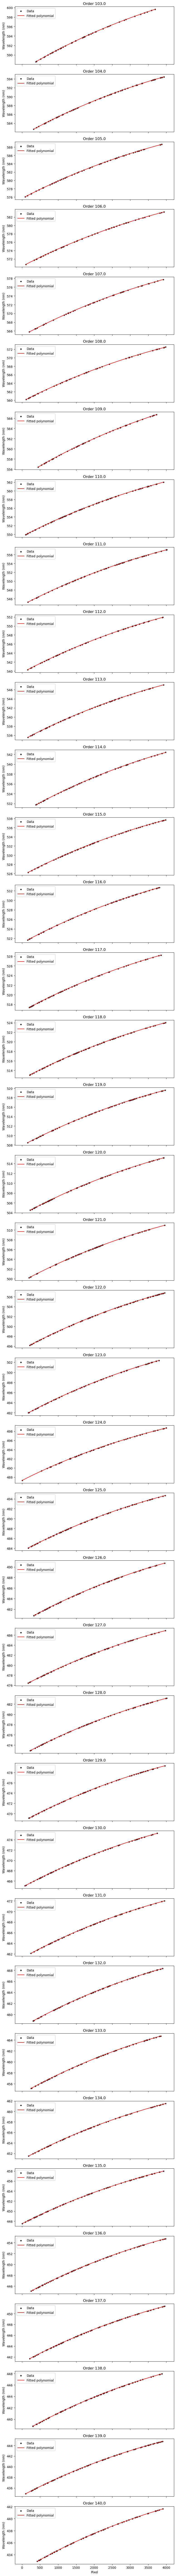

In [ ]:
%matplotlib inline
plt.close('all')

unique_orders = np.unique(order_positions)
fig, axs = plt.subplots(len(unique_orders), 1, figsize=(8, 3 * len(unique_orders)), sharex=True)

if len(unique_orders) == 1:
    axs = [axs]

for i, order in enumerate(unique_orders):
    mask = order_positions == order
    x = pixel_positions[mask]
    y = wave_positions[mask]
    poly, residuals, inlier_mask = polynomials[order]
    x_fit = np.linspace(x.min(), x.max(), 500)
    y_fit = poly(x_fit)
    axs[i].scatter(x, y, s=10, c='k', label='Data')
    axs[i].plot(x_fit, y_fit, 'r-', label='Fitted polynomial')
    axs[i].set_title(f'Order {order}')
    axs[i].set_ylabel('Wavelength (nm)')
    axs[i].legend()

axs[-1].set_xlabel('Pixel')
plt.tight_layout()
plt.show()

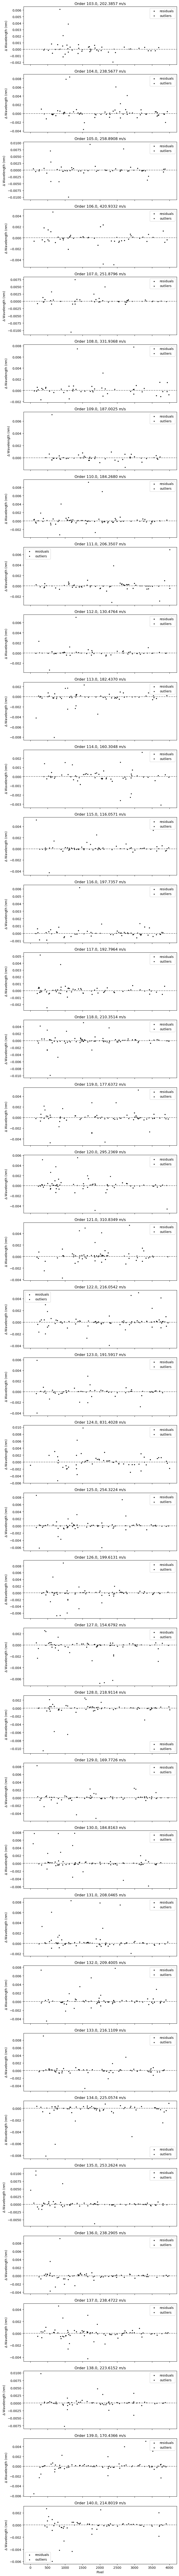

In [151]:
%matplotlib inline
plt.close('all')

unique_orders = np.unique(order_positions)
fig, axs = plt.subplots(len(unique_orders), 1, figsize=(8, 3 * len(unique_orders)), sharex=True)

if len(unique_orders) == 1:
    axs = [axs]

for i, order in enumerate(unique_orders):
    mask = order_positions == order
    x = pixel_positions[mask]
    y = wave_positions[mask]
    poly, residuals, inlier_mask = polynomials[order]
    # x_fit = np.linspace(x.min(), x.max(), 500)
    y_fit = poly(x)
    axs[i].scatter(x[inlier_mask], y[inlier_mask] - y_fit[inlier_mask], marker='o', s=5, color='k', label='residuals')
    axs[i].scatter(x[~inlier_mask], y[~inlier_mask] - y_fit[~inlier_mask], marker='x', s=5, color='k', label='outliers')
    _wave = poly(np.arange(4012))
     
    axs[i].axhline(0, color='gray', ls='--')
    # axs[i].plot(x_fit, y_fit, 'r-', label='Fitted polynomial')
    # uncertainty = np.std(residuals[inlier_mask])/np.sqrt(np.sum(inlier_mask)) * np.nanmean(np.diff(_wave)) / np.nanmean(_wave) * c
    # uncertainty = np.std(residuals[inlier_mask]) * np.nanmean(np.diff(_wave)) / np.nanmean(_wave) * c
    uncertainty = np.std(residuals[inlier_mask]) / np.nanmean(_wave) * c
    axs[i].set_title(f'Order {order}, {uncertainty:.4f} m/s')
    axs[i].set_ylabel(r'$\Delta$ Wavelength (nm)')
    axs[i].legend()

axs[-1].set_xlabel('Pixel')
plt.tight_layout()
plt.show()

##### Plot Surface Fit

In [110]:
%matplotlib widget

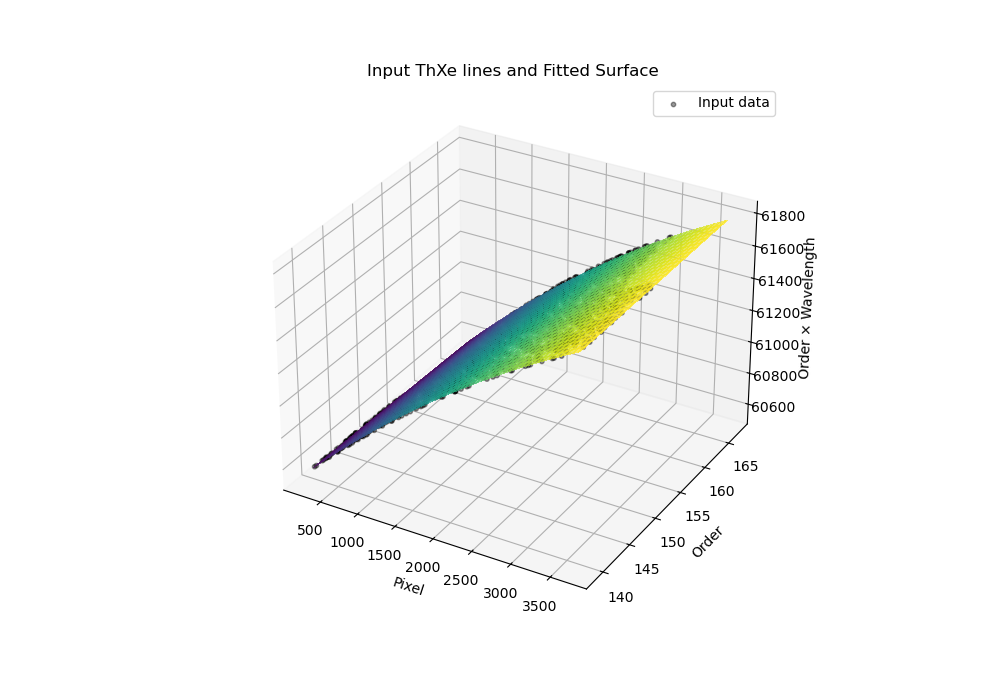

In [120]:
plt.close('all')

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot fitted surface
X, Y = np.meshgrid(full_pixels[0], np.unique(order_positions))
ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.7, linewidth=0, antialiased=False)

# Plot input data points
# ax.scatter(fitted_points[:, 0], fitted_points[:, 1], fitted_points[:, 2], c='r', s=10, label='Input data', alpha=0.5)
ax.scatter(pixel_positions, order_positions, order_positions*wave_positions, c='k', s=10, label='Input data', alpha=0.4)
# ax.scatter(pixel_positions[mask], order_positions[mask], order_positions[mask]*wave_positions[mask], c='r', s=10, label='Input data', alpha=0.6)
# ax.scatter(pixel_positions, order_positions, wave_positions, c='k', s=10, label='Input data', alpha=0.5)

ax.set_xlabel('Pixel')
ax.set_ylabel('Order')
ax.set_zlabel('Order × Wavelength')
ax.set_title('Input ThXe lines and Fitted Surface')
ax.legend()
plt.show()

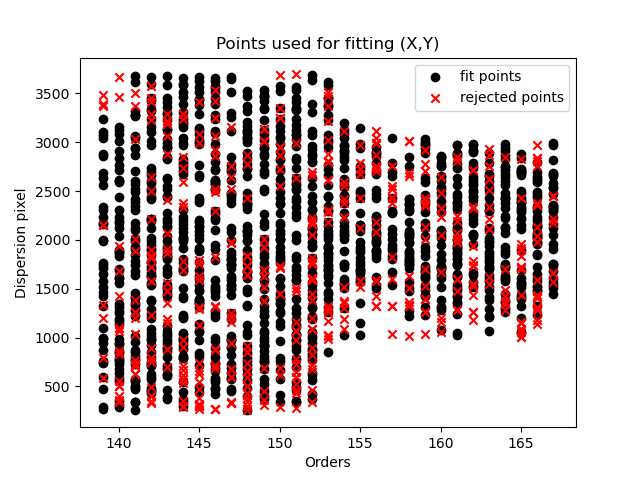

In [145]:
plt.close('all')
order = 9

fig, ax = plt.subplots()
ax.scatter(order_positions[mask], pixel_positions[mask], color='k', marker='o', label='fit points')
ax.scatter(order_positions[~mask], pixel_positions[~mask], color='r', marker='x', label='rejected points')

ax.set_xlabel('Orders')
ax.set_ylabel('Dispersion pixel')
ax.set_title('Points used for fitting (X,Y)')
plt.legend()
plt.show()

In [124]:
residuals.shape[0], np.sum(mask)

(1738, 1278)

In [125]:
stdev_vel = np.std(residuals[mask]/order_positions[mask])/np.mean(wave_positions[mask])*c

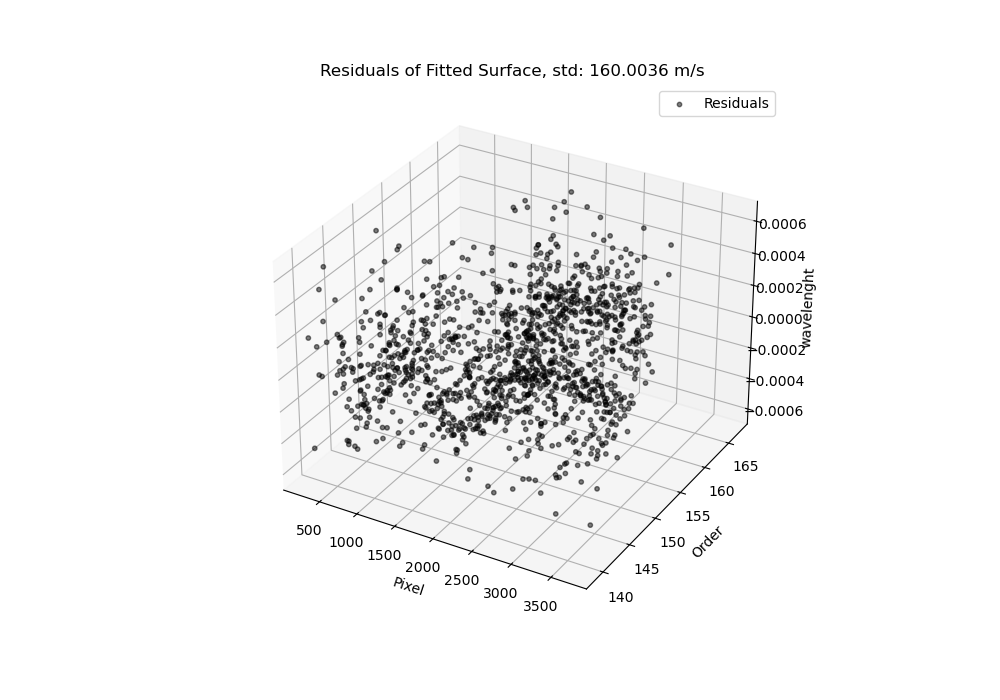

In [126]:
plt.close('all')

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot fitted surface
# X, Y = np.meshgrid(full_pixels[0], np.unique(order_positions))
# ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.7, linewidth=0, antialiased=False)

# Plot input data points
# ax.scatter(fitted_points[:, 0], fitted_points[:, 1], residuals/fitted_points[:, 1], c='k', s=10, label='Residuals', alpha=0.5)
# ax.scatter(pixel_positions, order_positions, order_positions*wave_positions, c='k', s=10, label='Residuals', alpha=0.5)
# ax.scatter(pixel_positions, order_positions, wave_positions, c='k', s=10, label='IResiduals', alpha=0.5)
# ax.scatter(pixel_positions, order_positions, residuals/order_positions/wave_positions*c, c='k', s=10, label='Residuals', alpha=0.5)
# ax.scatter(pixel_positions[mask], order_positions[mask], residuals[mask]/order_positions[mask]/wave_positions[mask]*c, c='k', s=10, label='Residuals', alpha=0.5)
ax.scatter(pixel_positions[mask], order_positions[mask], residuals[mask]/order_positions[mask], c='k', s=10, label='Residuals', alpha=0.5)

ax.set_xlabel('Pixel')
ax.set_ylabel('Order')
# ax.set_zlabel('m/s')
ax.set_zlabel('wavelenght')
ax.set_title('Residuals of Fitted Surface, std: {:.4f} m/s'.format(stdev_vel))
ax.legend()
plt.show()

In [147]:
# new_wave = [np.array(Z[i, int(min(trace_y)):int(max(trace_y)+1)])/absolute_order for i, absolute_order, trace_y in zip(range(len(ORDER)), ORDER, traces.y)]
new_wave = [model.predict((np.column_stack([trace_y, np.ones_like(trace_y)*absolute_order])))/absolute_order for i, absolute_order, trace_y in zip(range(len(ORDER)), ORDER, traces.y)]
for w in new_wave:
    print(min(w), max(w))

435.8829943507064 444.48286785177265
432.7642348640886 441.30393188287314
429.68961052433053 438.1736812144824
426.6581874412278 435.0841860447269
423.669058216364 432.04145279815384
420.72134103548086 429.03769463625395
417.8141787984049 426.0788768375314
414.946738284731 423.159032545156
412.1182093535592 420.2773644140644
409.3278041756753 417.4380806731957
406.57475649664923 414.6337271384921
403.8583209294111 411.8701627468181
401.1777722749351 409.14168783116446
398.53240486973954 406.44922616318655
397.49517042755434 403.79206904201465
395.446778196741 400.31983591445515
392.89102882005596 397.6735537882663
390.3680211004629 395.06435558513
387.8771313731384 392.4880009290057
385.417752076484 389.94205364017466
382.9892912568054 387.42950643054974
380.5911720915668 384.94976520500313
378.2228324304121 382.5563968771946
375.8837243531851 380.1962137343757
373.573313744219 377.8614898581939
371.29107988220085 375.55882839346464
369.03651504494985 373.28060712767206
366.80912412848

In [148]:
np.std(residuals) / np.sqrt(len(residuals)) * np.nanmean(np.diff(wave[20])) / np.nanmean(wave[20]) * c

9.90702234210712

##### Plot spectra with wave solution

In [112]:
%matplotlib widget

Found 73 lines in the order.


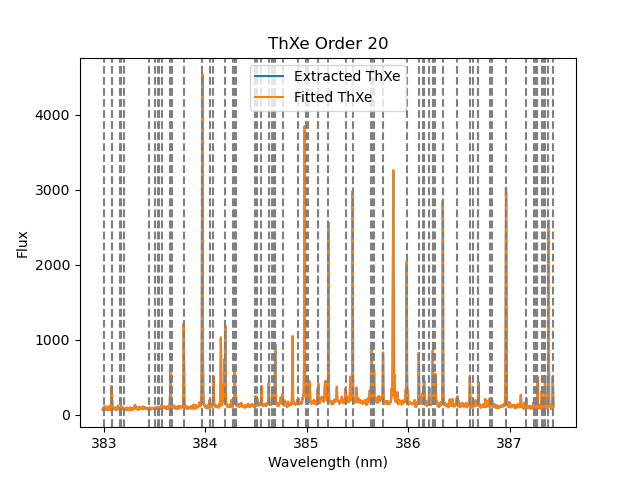

In [149]:
order = 20
plt.close('all')
plt.plot(veloce_reduction_tools.vacuum_to_air(wave[order]), extracted_ThXe[order], label='Extracted ThXe')
plt.plot(new_wave[order], extracted_ThXe[order], label='Fitted ThXe')
lines = get_lines_in_order(new_wave[order], nist_linelist, elements=['Th', 'Xe'], intensity_threshold=200, flag=['1'])
for line in lines:
    plt.axvline(line['obs_wl_air(nm)'], color='grey', linestyle='--')
# Remove duplicate labels in legend
handles, labels = plt.gca().get_legend_handles_labels()
unique = dict()
for h, l in zip(handles, labels):
    if l not in unique:
        unique[l] = h
plt.legend(unique.values(), unique.keys())
plt.xlabel('Wavelength (nm)')
plt.ylabel('Flux')
plt.title(f'ThXe Order {order}')
plt.legend()
plt.show()  

Found 61 lines in the order.


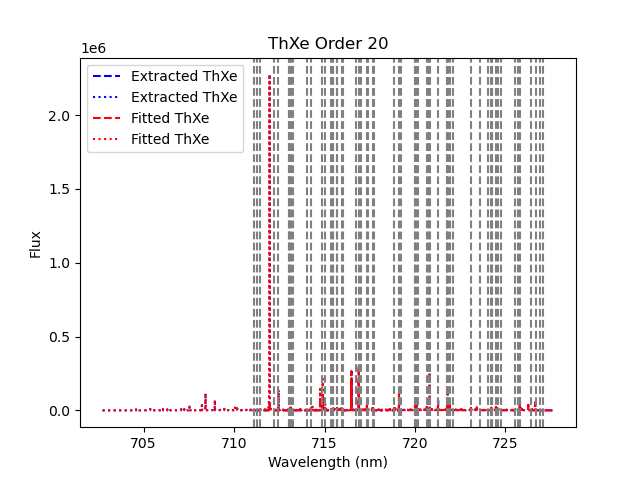

In [85]:
order = 20
plt.close('all')
plt.plot(veloce_reduction_tools.vacuum_to_air(wave[order]), extracted_ThXe[order], 'b--', label='Extracted ThXe')
plt.plot(veloce_reduction_tools.vacuum_to_air(wave[order+1]), extracted_ThXe[order+1], 'b:', label='Extracted ThXe')
plt.plot(new_wave[order], extracted_ThXe[order], 'r--', label='Fitted ThXe')
plt.plot(new_wave[order+1], extracted_ThXe[order+1], 'r:', label='Fitted ThXe')
lines = get_lines_in_order(new_wave[order], nist_linelist, elements=['Th', 'Xe'], intensity_threshold=200, flag=['1'])
for line in lines:
    plt.axvline(line['obs_wl_air(nm)'], color='grey', linestyle='--')
# Remove duplicate labels in legend
handles, labels = plt.gca().get_legend_handles_labels()
unique = dict()
for h, l in zip(handles, labels):
    if l not in unique:
        unique[l] = h
plt.legend(unique.values(), unique.keys())
plt.xlabel('Wavelength (nm)')
plt.ylabel('Flux')
plt.title(f'ThXe Order {order}')
plt.legend()
plt.show()

##### Save ThXe static WAVE SOLUTION

In [150]:
with open('./Wave/ThXe_wave_{date}_{arm}.pkl'.format(date=date, arm=arm), 'wb') as f:
    pickle.dump(new_wave, f)

##### validate arms overlap

In [151]:
# date = '230826'
date = '240410'
new_green_wave = pickle.load(open(os.path.join(veloce_paths.wave_dir, f'ThXe_wave_{date}_green.pkl'), 'rb'))
new_red_wave = pickle.load(open(os.path.join(veloce_paths.wave_dir, f'ThXe_wave_{date}_red.pkl'), 'rb'))
new_blue_wave = pickle.load(open(os.path.join(veloce_paths.wave_dir, f'ThXe_wave_{date}_blue.pkl'), 'rb'))


In [152]:
red_traces = veloce_reduction_tools.Traces.load_traces(os.path.join(veloce_paths.trace_dir, 'veloce_red_4amp_sim_calib_trace.pkl'))
green_traces = veloce_reduction_tools.Traces.load_traces(os.path.join(veloce_paths.trace_dir, 'veloce_green_4amp_sim_calib_trace.pkl'))
blue_traces = veloce_reduction_tools.Traces.load_traces(os.path.join(veloce_paths.trace_dir, 'veloce_blue_4amp_sim_calib_trace.pkl'))

In [153]:
ORDER, COEFFS, MATCH_LAM, MATCH_PIX, MATCH_LRES, GUESS_LAM, Y0 = veloce_reduction_tools.load_prefitted_wave(arm='green', wave_path=veloce_paths.wave_dir)
old_green_wave = veloce_reduction_tools.calibrate_orders_to_wave(None, Y0, COEFFS, traces=green_traces)

In [154]:
ORDER, COEFFS, MATCH_LAM, MATCH_PIX, MATCH_LRES, GUESS_LAM, Y0 = veloce_reduction_tools.load_prefitted_wave(arm='red', wave_path=veloce_paths.wave_dir)
old_red_wave = veloce_reduction_tools.calibrate_orders_to_wave(None, Y0, COEFFS, traces=red_traces)

In [155]:
ORDER, COEFFS, MATCH_LAM, MATCH_PIX, MATCH_LRES, GUESS_LAM, Y0 = veloce_reduction_tools.load_prefitted_wave(arm='blue', wave_path=veloce_paths.wave_dir)
old_blue_wave = veloce_reduction_tools.calibrate_orders_to_wave(None, Y0, COEFFS, traces=blue_traces)

In [156]:
master_filename = f'{veloce_paths.master_dir}/master_ARC-ThAr_red_{date}.fits'
# veloce_reduction_tools.save_image_fits(master_filename, data, header)
with fits.open(master_filename) as hdul:
    red_data= hdul[0].data
    header = hdul[0].header
master_filename = f'{veloce_paths.master_dir}/master_ARC-ThAr_green_{date}.fits'
# veloce_reduction_tools.save_image_fits(master_filename, data, header)
with fits.open(master_filename) as hdul:
    green_data= hdul[0].data
    header = hdul[0].header
master_filename = f'{veloce_paths.master_dir}/master_ARC-ThAr_blue_{date}.fits'
# veloce_reduction_tools.save_image_fits(master_filename, data, header)
with fits.open(master_filename) as hdul:
    blue_data= hdul[0].data
    header = hdul[0].header

In [157]:
red_extracted_thxe, _ = veloce_reduction_tools.extract_orders_with_trace(red_data, red_traces)
green_extracted_thxe, _ = veloce_reduction_tools.extract_orders_with_trace(green_data, green_traces)
blue_extracted_thxe, _ = veloce_reduction_tools.extract_orders_with_trace(blue_data, blue_traces)

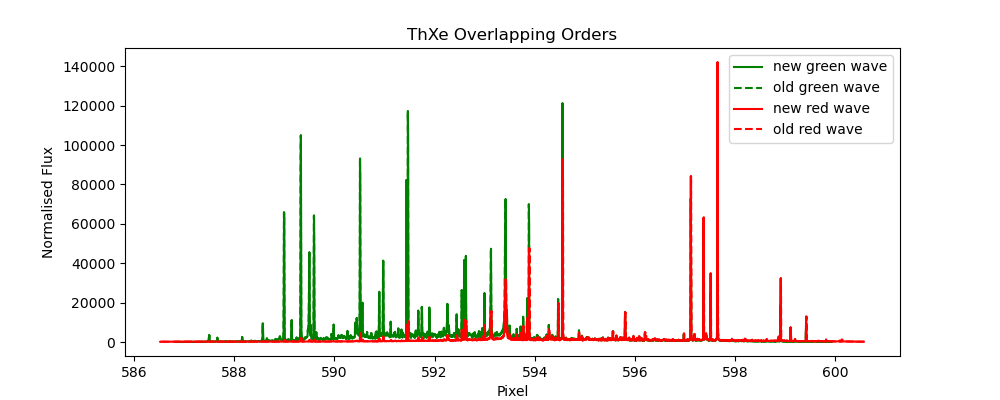

In [158]:
green_order = 0
red_order = -2
plt.figure(figsize=(10, 4))
plt.plot(new_green_wave[green_order], green_extracted_thxe[green_order], 'g-', label='new green wave')
plt.plot(veloce_reduction_tools.vacuum_to_air(old_green_wave[green_order]), green_extracted_thxe[green_order], 'g--', label='old green wave')
plt.plot(new_red_wave[red_order], red_extracted_thxe[red_order], 'r-', label='new red wave')
plt.plot(veloce_reduction_tools.vacuum_to_air(old_red_wave[red_order]), red_extracted_thxe[red_order], 'r--', label='old red wave')
# plt.axhline(1, color='k', ls='--', label='Normalised Flux = 1')
plt.xlabel('Pixel')
plt.ylabel('Normalised Flux')
plt.title('ThXe Overlapping Orders')
plt.legend()
plt.show()

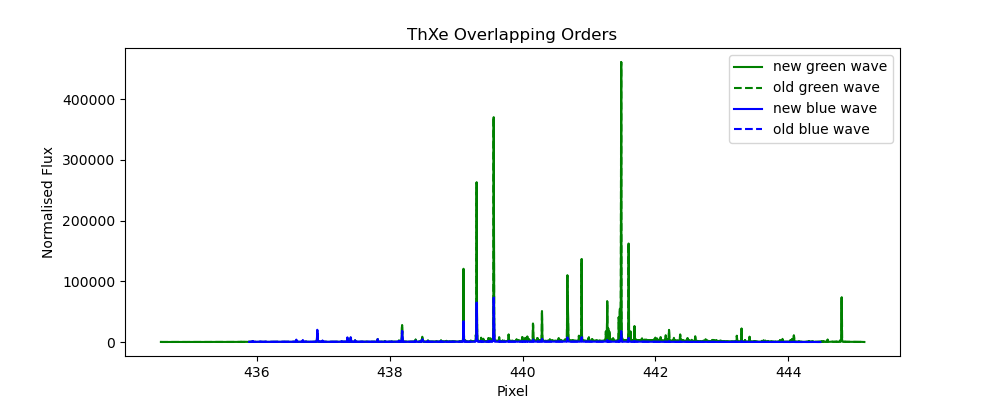

In [159]:
blue_order = 0
green_order = -2
plt.figure(figsize=(10, 4))
plt.plot(new_green_wave[green_order], green_extracted_thxe[green_order], 'g-', label='new green wave')
plt.plot(veloce_reduction_tools.vacuum_to_air(old_green_wave[green_order]), green_extracted_thxe[green_order], 'g--', label='old green wave')
plt.plot(new_blue_wave[blue_order], blue_extracted_thxe[blue_order], 'b-', label='new blue wave')
plt.plot(veloce_reduction_tools.vacuum_to_air(old_blue_wave[blue_order]), blue_extracted_thxe[blue_order], 'b--', label='old blue wave')
# plt.axhline(1, color='k', ls='--', label='Normalised Flux = 1')
plt.xlabel('Pixel')
plt.ylabel('Normalised Flux')
plt.title('ThXe Overlapping Orders')
plt.legend()
plt.show()

In [135]:
obs_list['science']

{'240410': []}

In [137]:
# load science obs
# night = '230826'
arm = 'red'
# night = '240410'
filename = '10apr30130.fits'
ccd = f'ccd_3'
amp_mode = 2
obs_filename =  os.path.join(veloce_paths.input_dir, date, ccd, filename)
with fits.open(obs_filename) as hdul:
    image_data = hdul[0].data
    header = hdul[0].header
image_substracted_bias = veloce_reduction_tools.remove_overscan_bias(image_data, header, arm, amp_mode, overscan_range=32)
# Extract obs
red_extracted_obs, _ = veloce_reduction_tools.extract_orders_with_trace(image_substracted_bias, red_traces)

Gain for amplifier 3 not found in header.
Gain for amplifier 4 not found in header.
Gain for half 1: 1.01
Gain for half 2: 1.040502


In [142]:
# load science obs
arm = 'green'
# night = '240410'
filename = '10apr20130.fits'
ccd = f'ccd_2'
amp_mode = 2
obs_filename =  os.path.join(veloce_paths.input_dir, date, ccd, filename)
with fits.open(obs_filename) as hdul:
    image_data = hdul[0].data
    header = hdul[0].header
image_substracted_bias = veloce_reduction_tools.remove_overscan_bias(image_data, header, arm, amp_mode, overscan_range=32)
# Extract obs
green_extracted_obs, _ = veloce_reduction_tools.extract_orders_with_trace(image_substracted_bias, green_traces)

Gain for amplifier 3 not found in header.
Gain for amplifier 4 not found in header.
Gain for half 1: 1.01
Gain for half 2: 1.022423


In [147]:
def normalise_science_order(y, nknots=10, plot=False):
    """
    Normalise the order by fitting a spline.
    """
    median_step = int(len(y) / (nknots*2) + 1)
    # maximum_step = median_step * 2
    maximum_step = median_step / 10
    print(f"Median step: {median_step}, Maximum step: {maximum_step}, N knots: {nknots}")
    x = np.arange(len(y))
    # smoothed = maximum_filter(median_filter(y, size=median_step), size=maximum_step)
    smoothed = median_filter(maximum_filter(y, size=maximum_step), size=median_step)
    # smoothed = median_filter(y, size=median_step)
    x_fit = np.linspace(x.min(), x.max(), nknots)
    y_fit = np.interp(x_fit, x, smoothed)
    spline = make_interp_spline(x_fit, y_fit, k=3)
    baseline = spline(x)
    
    if plot:
        plt.figure(figsize=(10, 6))
        plt.plot(x, y, c='gray', label='Original', alpha=0.5)
        plt.plot(x, smoothed, ls='--', c='k', label='Smoothed')
        plt.scatter(x_fit, y_fit, s=10, c='k', label='Selected knots')
        plt.plot(x, baseline, c='r', label='B-spline fit')
        plt.xlabel('Pixel')
        plt.ylabel('Flux')
        plt.xlim(0, len(y))
        plt.ylim(0, np.max(smoothed) * 1.05)
        plt.legend()
        plt.title('Normalisation of science Order')
        plt.show()

    return y/baseline

Median step: 55, Maximum step: 5.5, N knots: 35


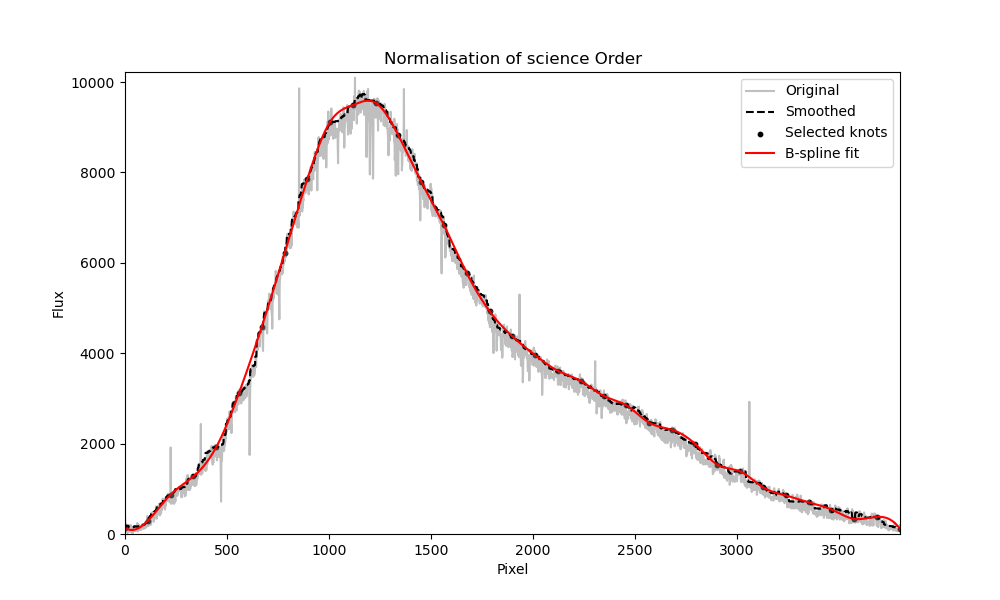

Median step: 52, Maximum step: 5.2, N knots: 40


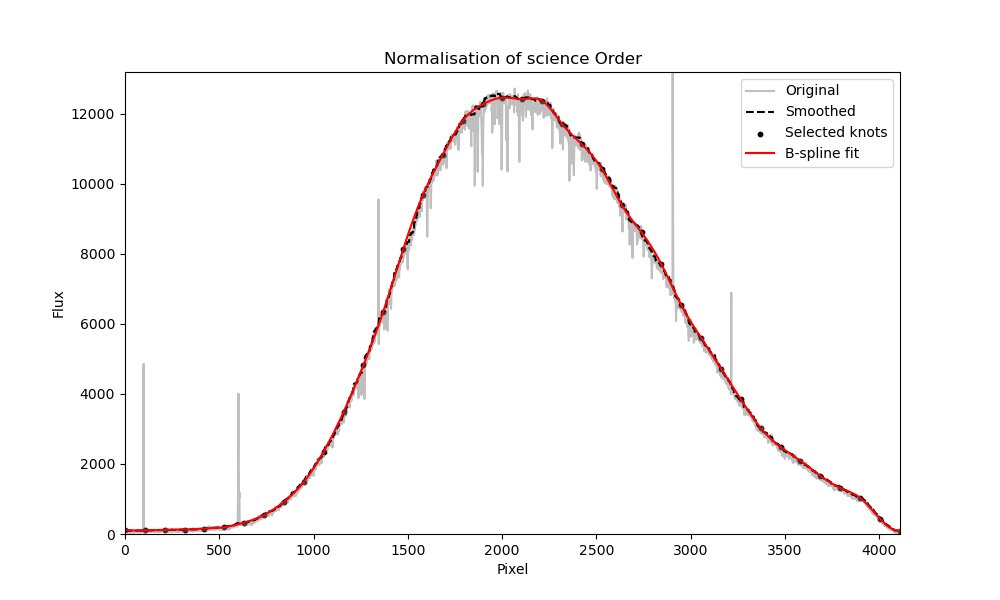

In [150]:
normalised_green_order = normalise_science_order(green_extracted_obs[0], nknots=35, plot=True)
normalised_red_order = normalise_science_order(red_extracted_obs[-2], nknots=40, plot=True)

Median step: 55, Maximum step: 5.5, N knots: 35
Median step: 55, Maximum step: 5.5, N knots: 35
Median step: 52, Maximum step: 5.2, N knots: 40
Median step: 52, Maximum step: 5.2, N knots: 40


/tmp/ipykernel_7658/640665915.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 4))


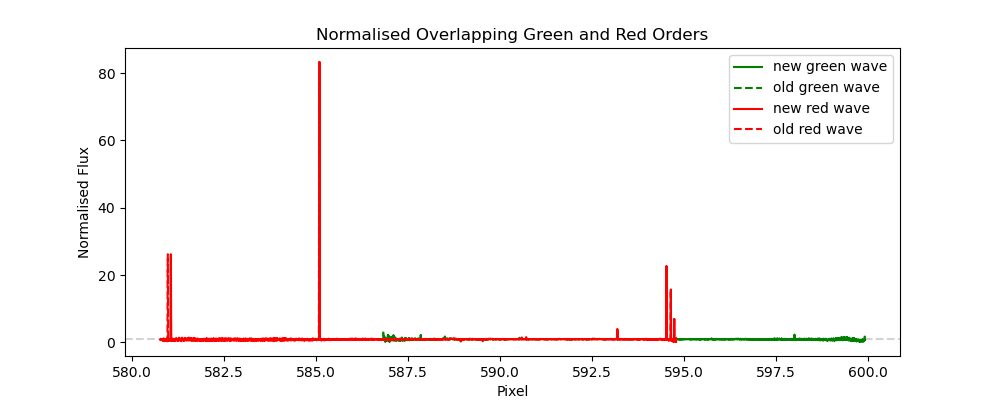

In [154]:
green_order = 0
red_order = -1
plt.figure(figsize=(10, 4))
plt.axhline(1, color='lightgrey', ls='--')

plt.plot(
    new_green_wave[green_order],
    normalise_science_order(green_extracted_obs[green_order], nknots=35, plot=False),
    'g-', label='new green wave')
plt.plot(
    veloce_reduction_tools.vacuum_to_air(old_green_wave[green_order]),
    normalise_science_order(green_extracted_obs[green_order], nknots=35, plot=False),
    'g--', label='old green wave')
plt.plot(new_red_wave[red_order],
    normalise_science_order(red_extracted_obs[red_order], nknots=40, plot=False),
    'r-', label='new red wave')
plt.plot(veloce_reduction_tools.vacuum_to_air(old_red_wave[red_order]),
        normalise_science_order(red_extracted_obs[red_order], nknots=40, plot=False),
        'r--', label='old red wave')

plt.xlabel('Pixel')
plt.ylabel('Normalised Flux')
plt.title('Normalised Overlapping Green and Red Orders')
plt.legend()
plt.show()